In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from munkres import Munkres
from scipy.special import comb
from PIL import Image
import random

In [2]:
def make_cost_matrix(c1, c2):
    """
    """
    uc1 = np.unique(c1)
    uc2 = np.unique(c2)
    l1 = uc1.size
    l2 = uc2.size
    assert(l1 == l2 and np.all(uc1 == uc2))

    m = np.ones([l1, l2])
    for i in range(l1):
        it_i = np.nonzero(c1 == uc1[i])[0]
        for j in range(l2):
            it_j = np.nonzero(c2 == uc2[j])[0]
            m_ij = np.intersect1d(it_j, it_i)
            m[i,j] =  -m_ij.size
    return m

def translate_clustering(clt, mapper):
    return np.array([ mapper[i] for i in clt ])



def map_label(pred, gt):
    """entry point"""

    num_labels = len(np.unique(gt))

    # cm = confusion_matrix(gt, pred, labels=range(num_labels)) # gets the confusion matrix

    cost_matrix = make_cost_matrix(pred, gt)

    m = Munkres()
    indexes = m.compute(cost_matrix)
    mapper = { old: new for (old, new) in indexes }


    new_labels = translate_clustering(pred, mapper)
    new_cm = confusion_matrix(gt, new_labels, labels=range(num_labels))
    return new_labels, mapper


In [3]:
classes = [dir for dir in os.listdir("test")]
classes.sort()

data = []
labels = []
fnames = []
idx = 3
for i, dir in enumerate(classes):
    for fname in os.listdir(os.path.join("test", dir)):
        data.append(np.load(os.path.join("test", dir, fname)))
        labels.append(i)
        fnames.append(os.path.join("test", dir, fname))


data = np.vstack(data)
labels = np.array(labels)
kmeans = KMeans(n_clusters=len(classes), random_state=0, n_init="auto").fit(data)

In [4]:
acc = []
total_mis = 0
clusters = []
new_cluster, cluster_map = map_label(kmeans.labels_, labels)
# cluster_map = {classes[old] : new for old, new in cluster_map.items()}
# print(cluster_map)
for i in range(len(classes)):
    mask = (labels == i)
    cluster = new_cluster[mask]
    cur_acc = (cluster == i).mean()
    acc.append(f"{cur_acc: .2f}")
    clusters.append(cluster)
    # if classes[i] == "Violin_Mode" or i == 0:
    #     print(kmeans.labels_[mask])

cluster_class = classes
# cluster_class = [""] * len(classes)
# for k,v in cluster_map.items():
#     cluster_class[v] += f"/{k}"

# for i in range(len(cluster_class)):
#     if cluster_class[i] == "":
#         cluster_class[i] = "None"




# print(cluster_map)


df = pd.DataFrame(acc + [(new_cluster == labels).mean()], columns = ["Acc"], index=classes + ["total"])
print(df)
# plt.figure()
# plt.plot(np.arange(len(classes)), mis)

                          Acc
1080Lines                0.78
1400Ripples              0.00
Air_Compressor           0.99
Blip                     0.50
Blip_Low_Frequency       0.93
Chirp                    0.00
Extremely_Loud           0.32
Fast_Scattering          0.84
Helix                    0.12
Koi_Fish                 0.53
Light_Modulation         0.64
Low_Frequency_Burst      0.56
Low_Frequency_Lines      0.52
No_Glitch                0.94
Paired_Doves             0.00
Power_Line               0.98
Repeating_Blips          0.50
Scattered_Light          0.46
Scratchy                 0.02
Tomte                    0.48
Violin_Mode              0.00
Wandering_Line           0.01
Whistle                  0.36
total                0.560357


(856,)
(0,)


IndexError: index 0 is out of bounds for axis 0 with size 0

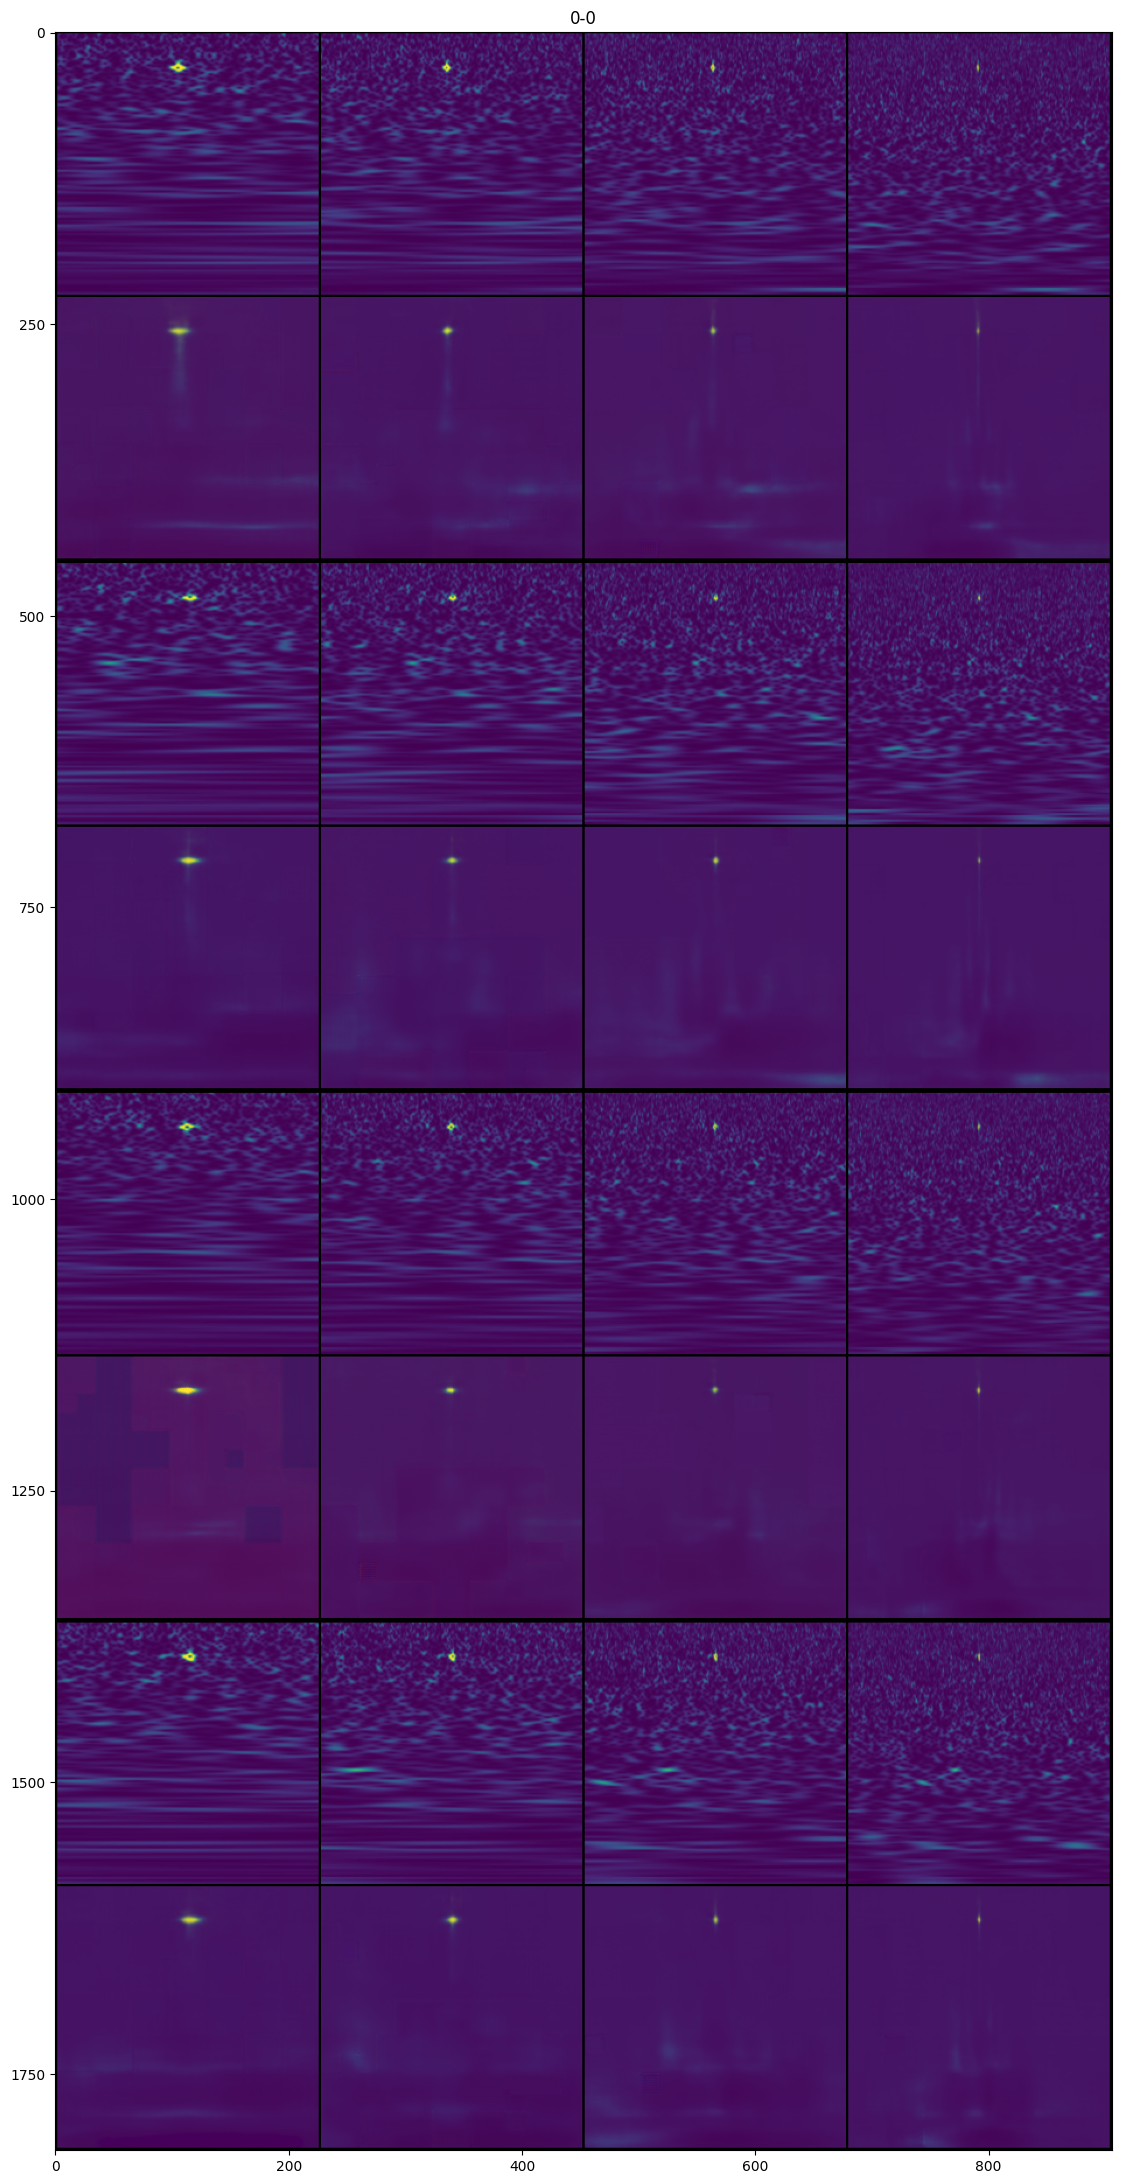

In [5]:
class_idx = 0
mis_class = 0
mask = (labels == class_idx)
fname = np.array(fnames)[mask][clusters[class_idx] == mis_class]
print(fname.shape)
random.shuffle(fname)
data = [np.array(Image.open(fname[i][:-4].replace("test", "test_im"))) for i in range(4)]
data = np.vstack(data)
fig = plt.figure(figsize=(30, 30)) 
fig.add_subplot(1, 2, 1)
plt.imshow(data)
plt.title(f"{class_idx}-{mis_class}")




class_idx = 0
mis_class = 21
mask = (labels == class_idx)
fname = np.array(fnames)[mask][clusters[class_idx] == mis_class]
print(fname.shape)
random.shuffle(fname)

data = [np.array(Image.open(fname[i][:-4].replace("test", "test_im"))) for i in range(4)]
data = np.vstack(data)
fig.add_subplot(1, 2, 2)
plt.imshow(data)
plt.title(f"{class_idx}-{mis_class}")

/local/yi.li/ipykernel_2854984/2359039482.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(20, 10))


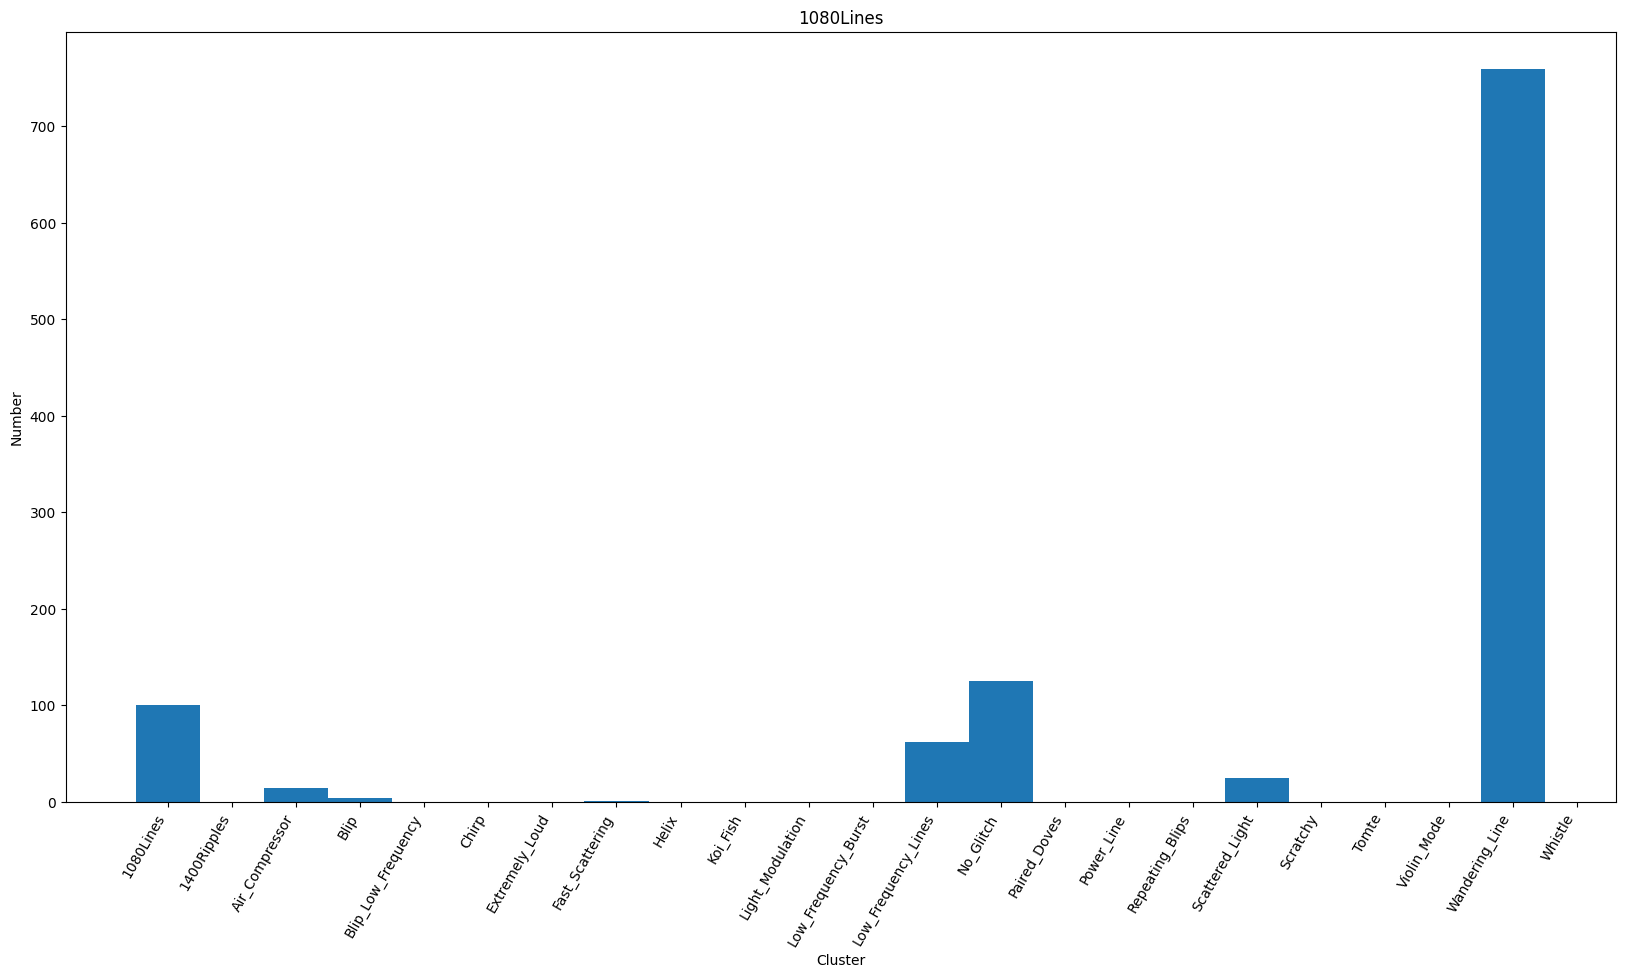

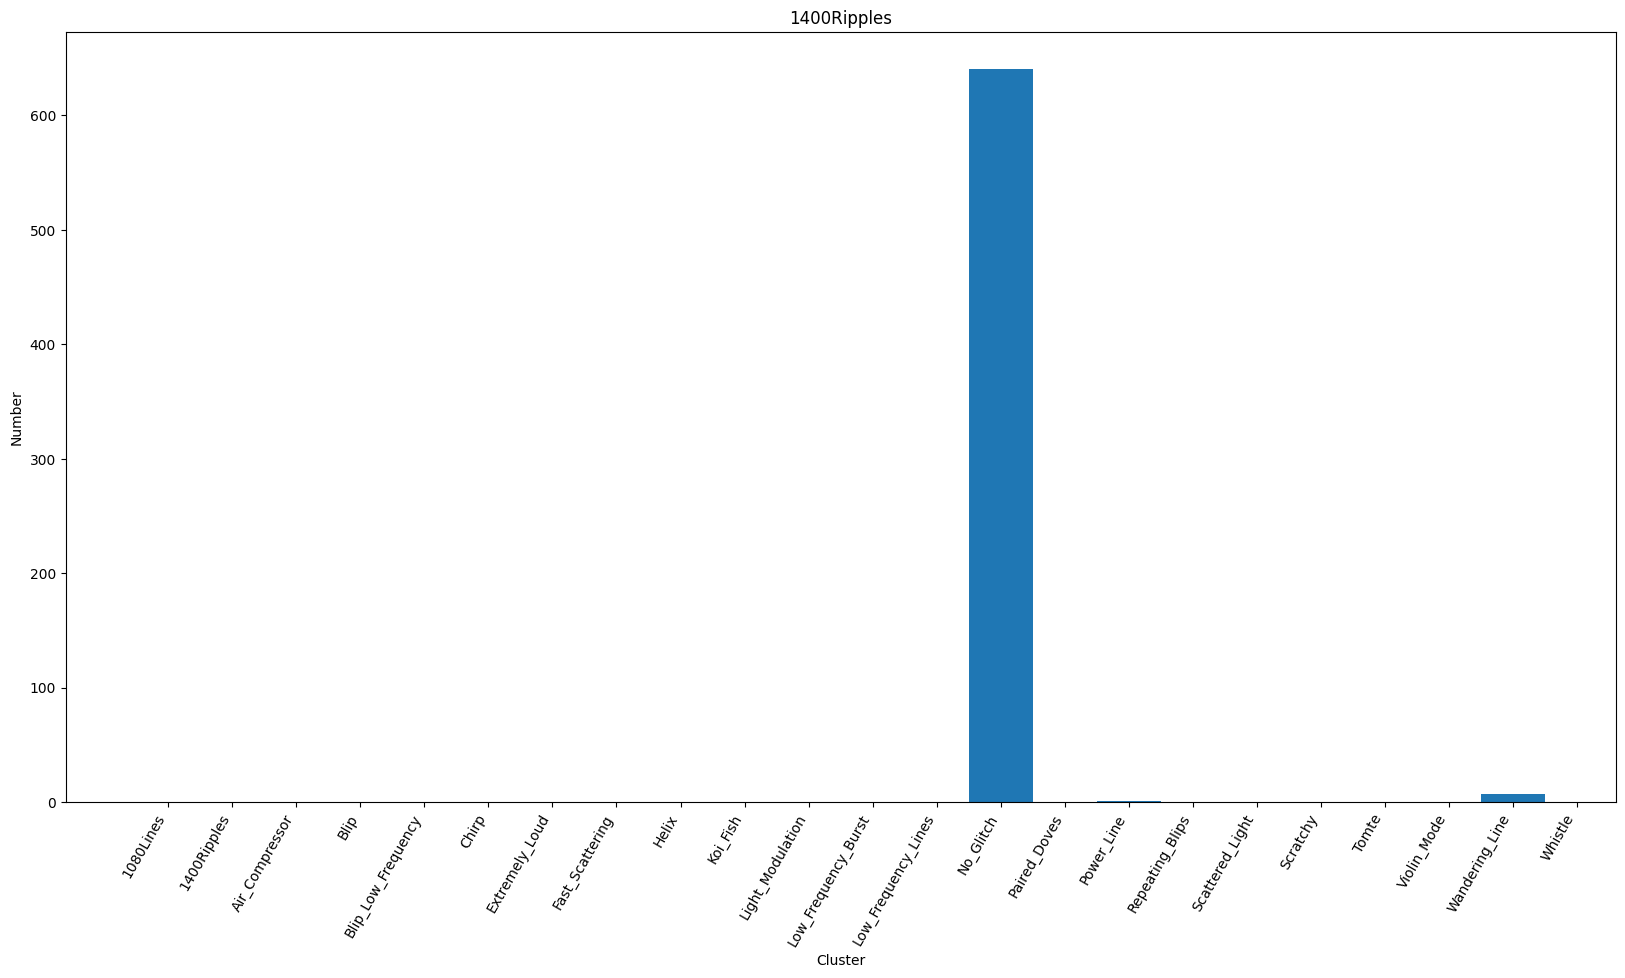

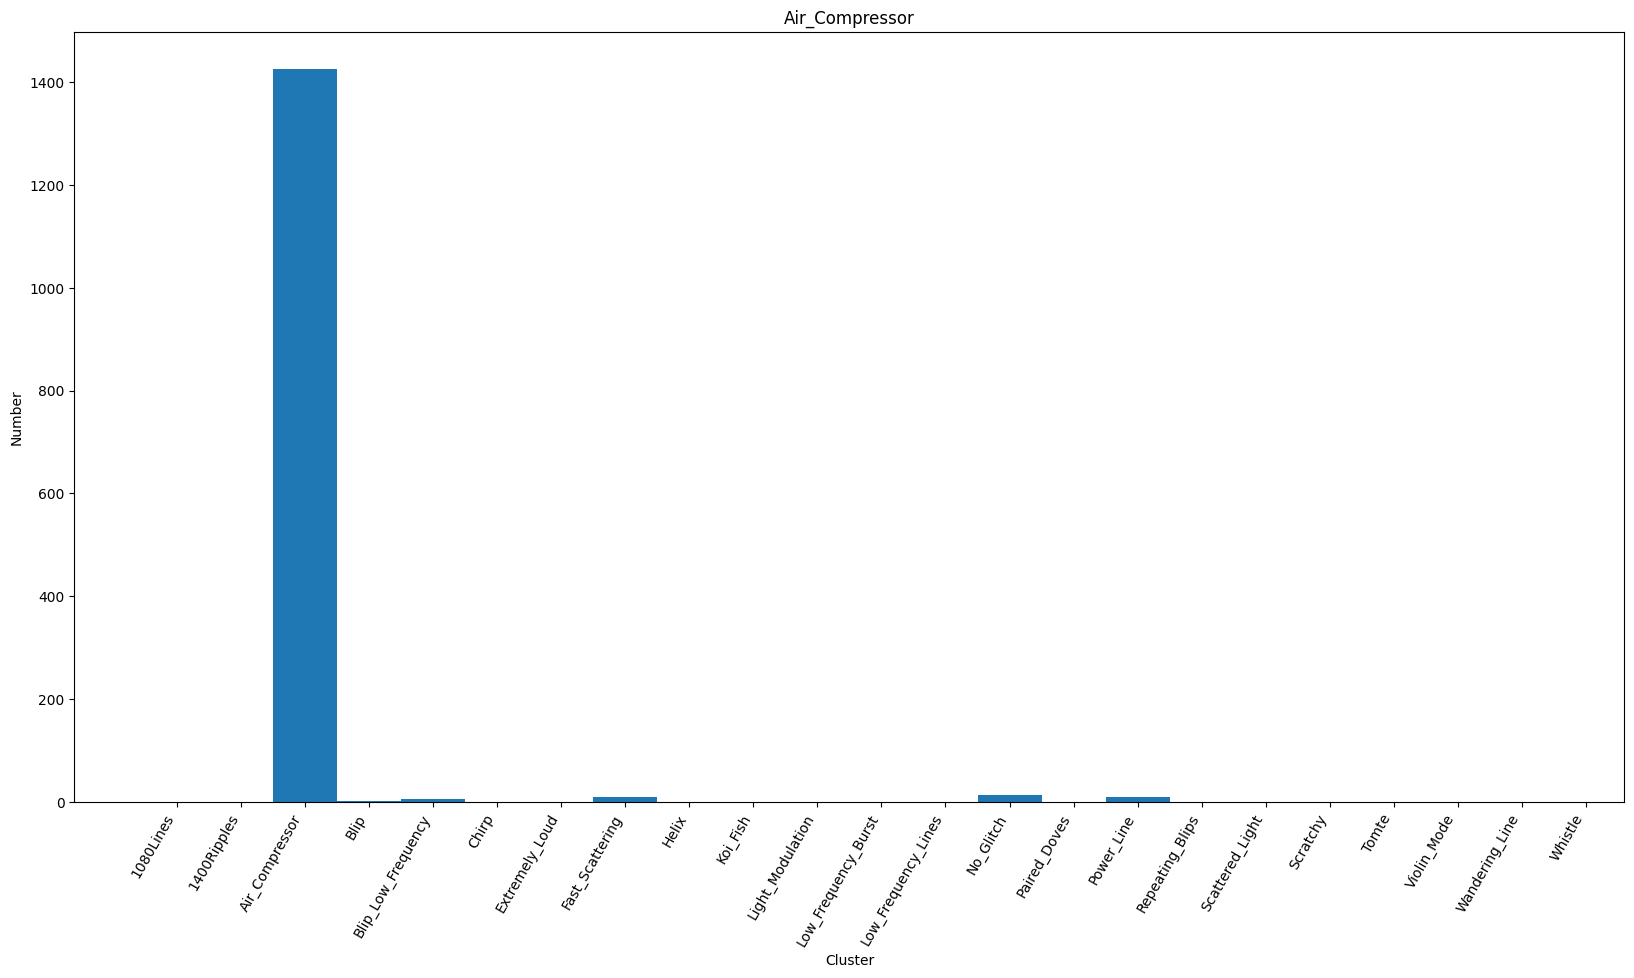

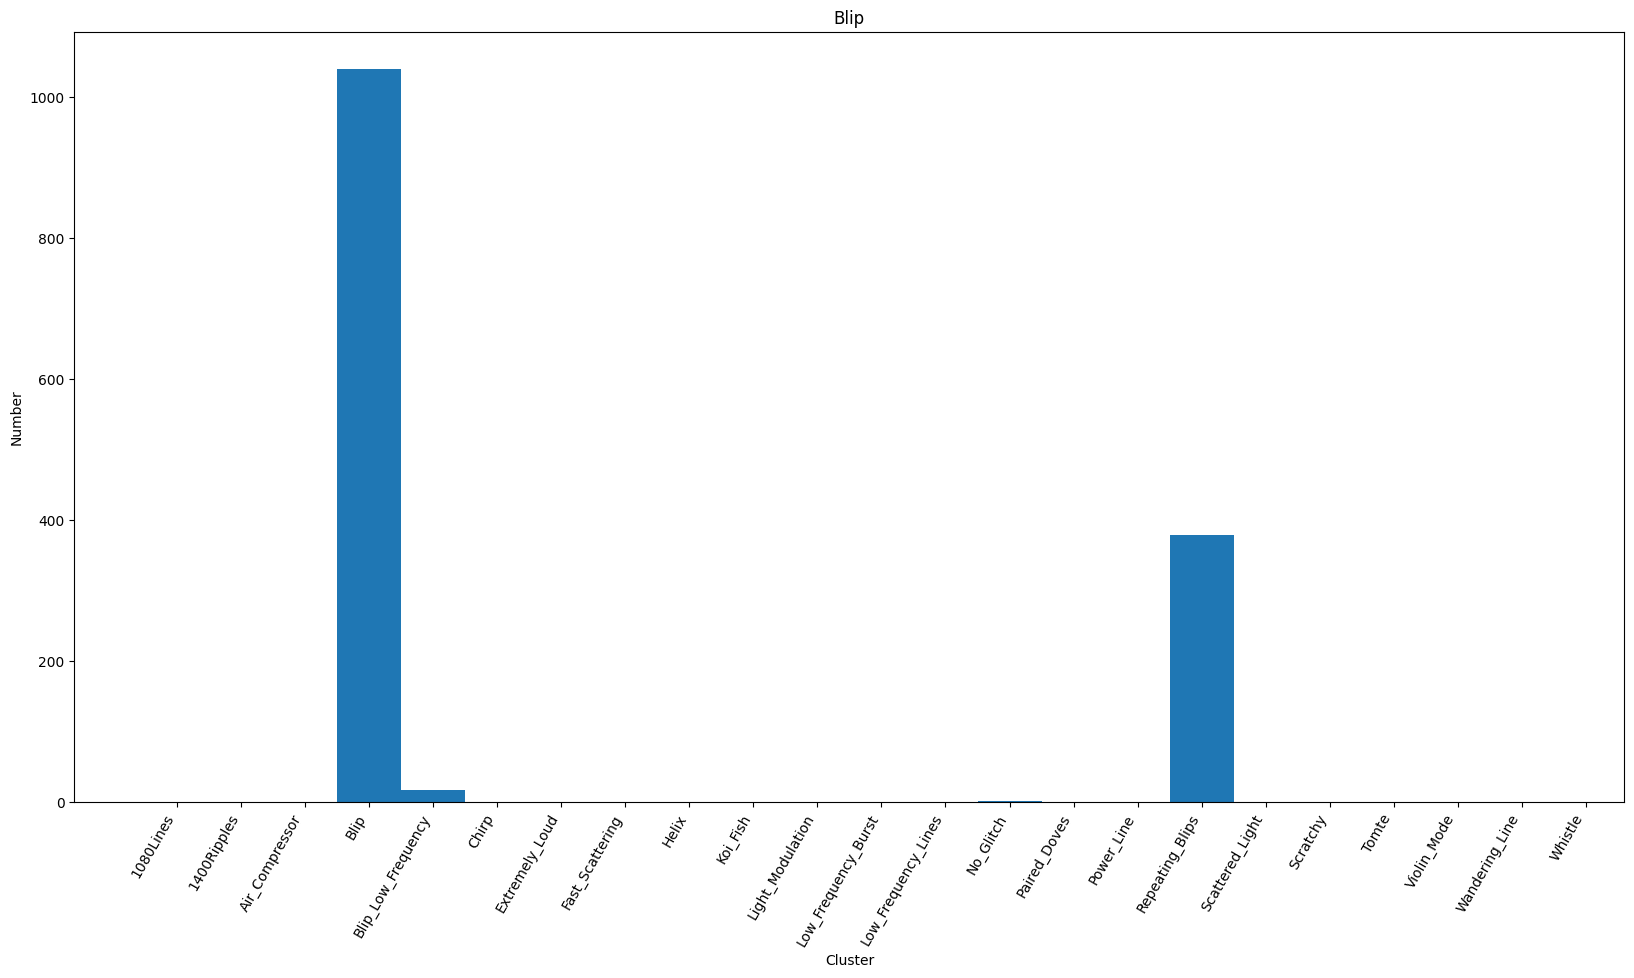

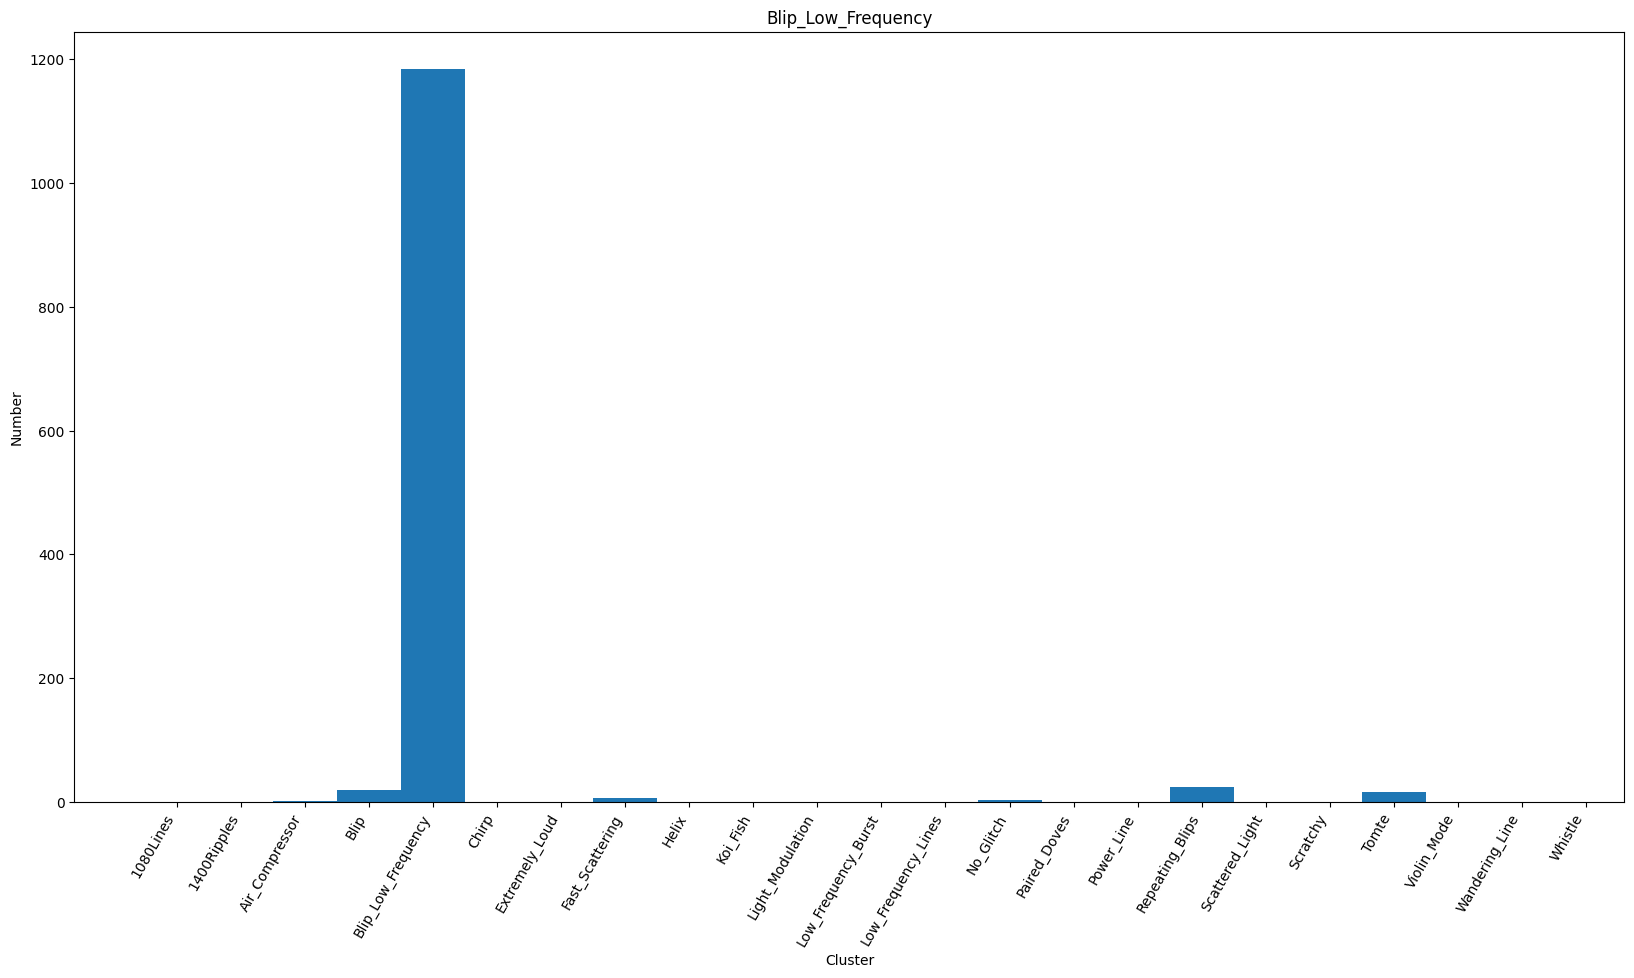

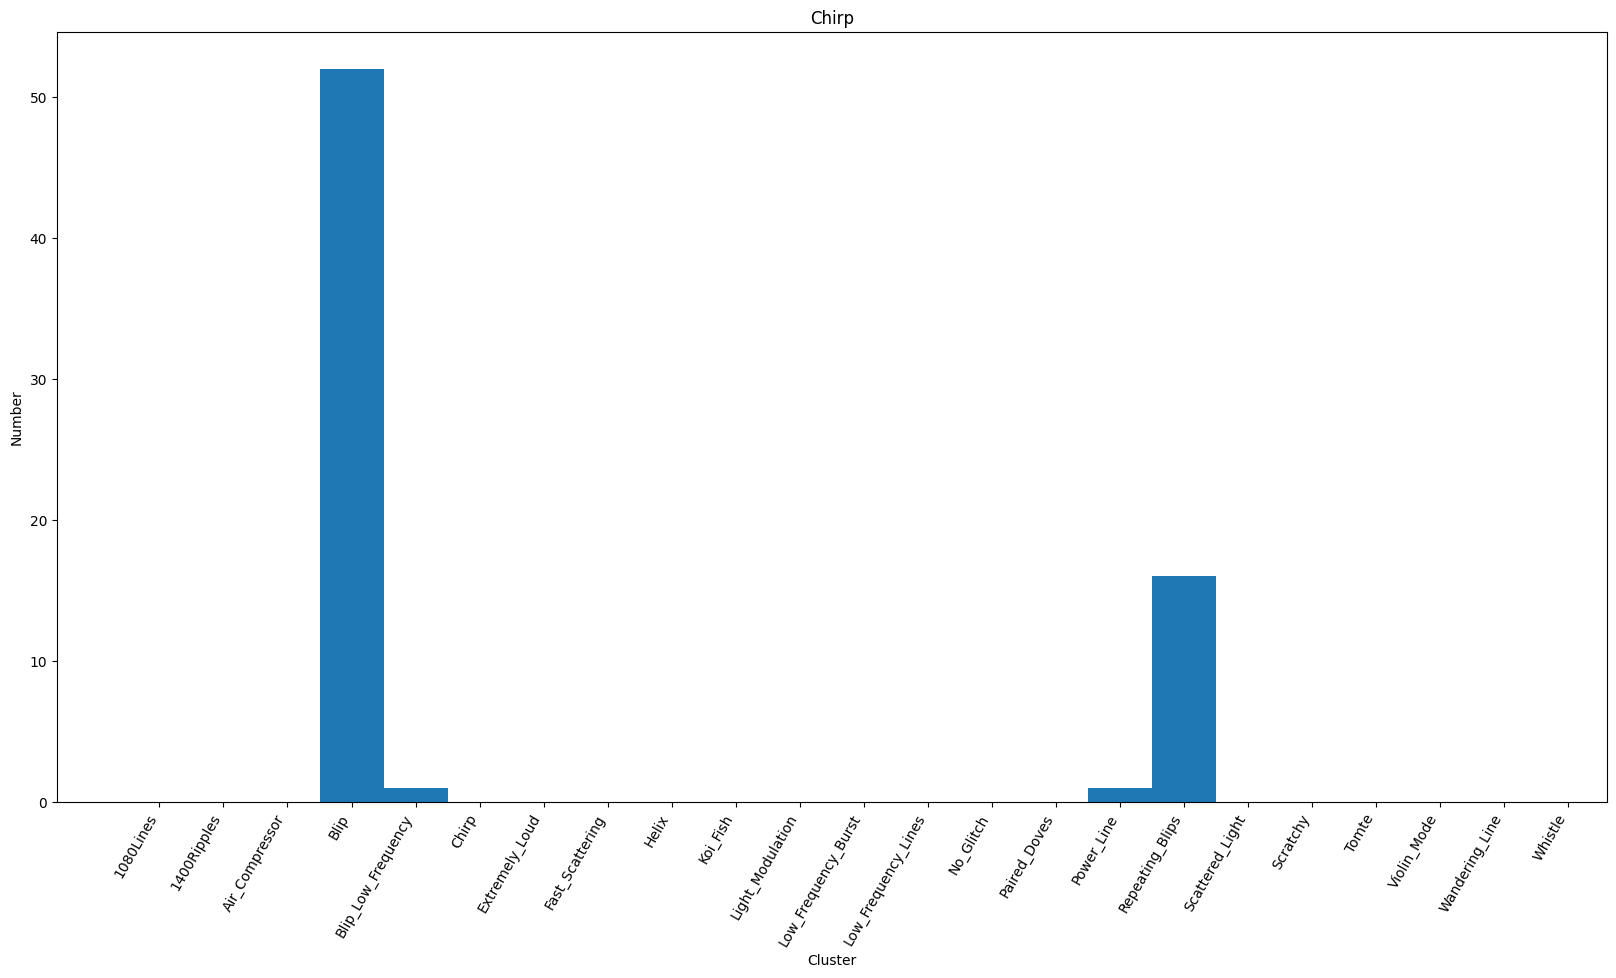

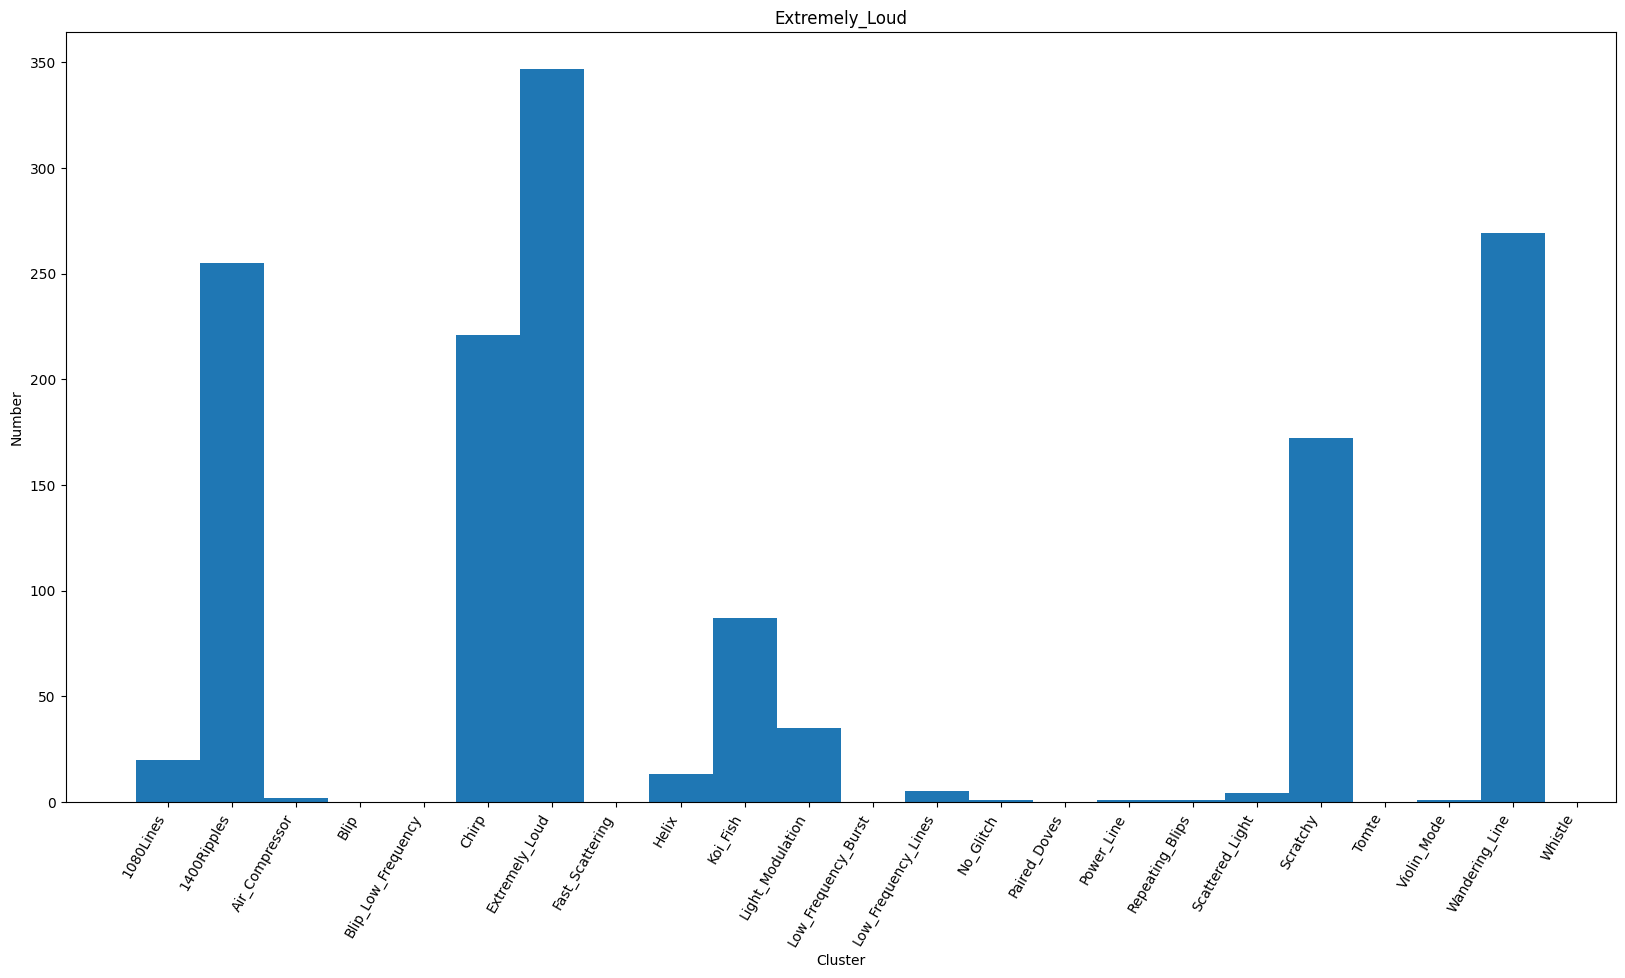

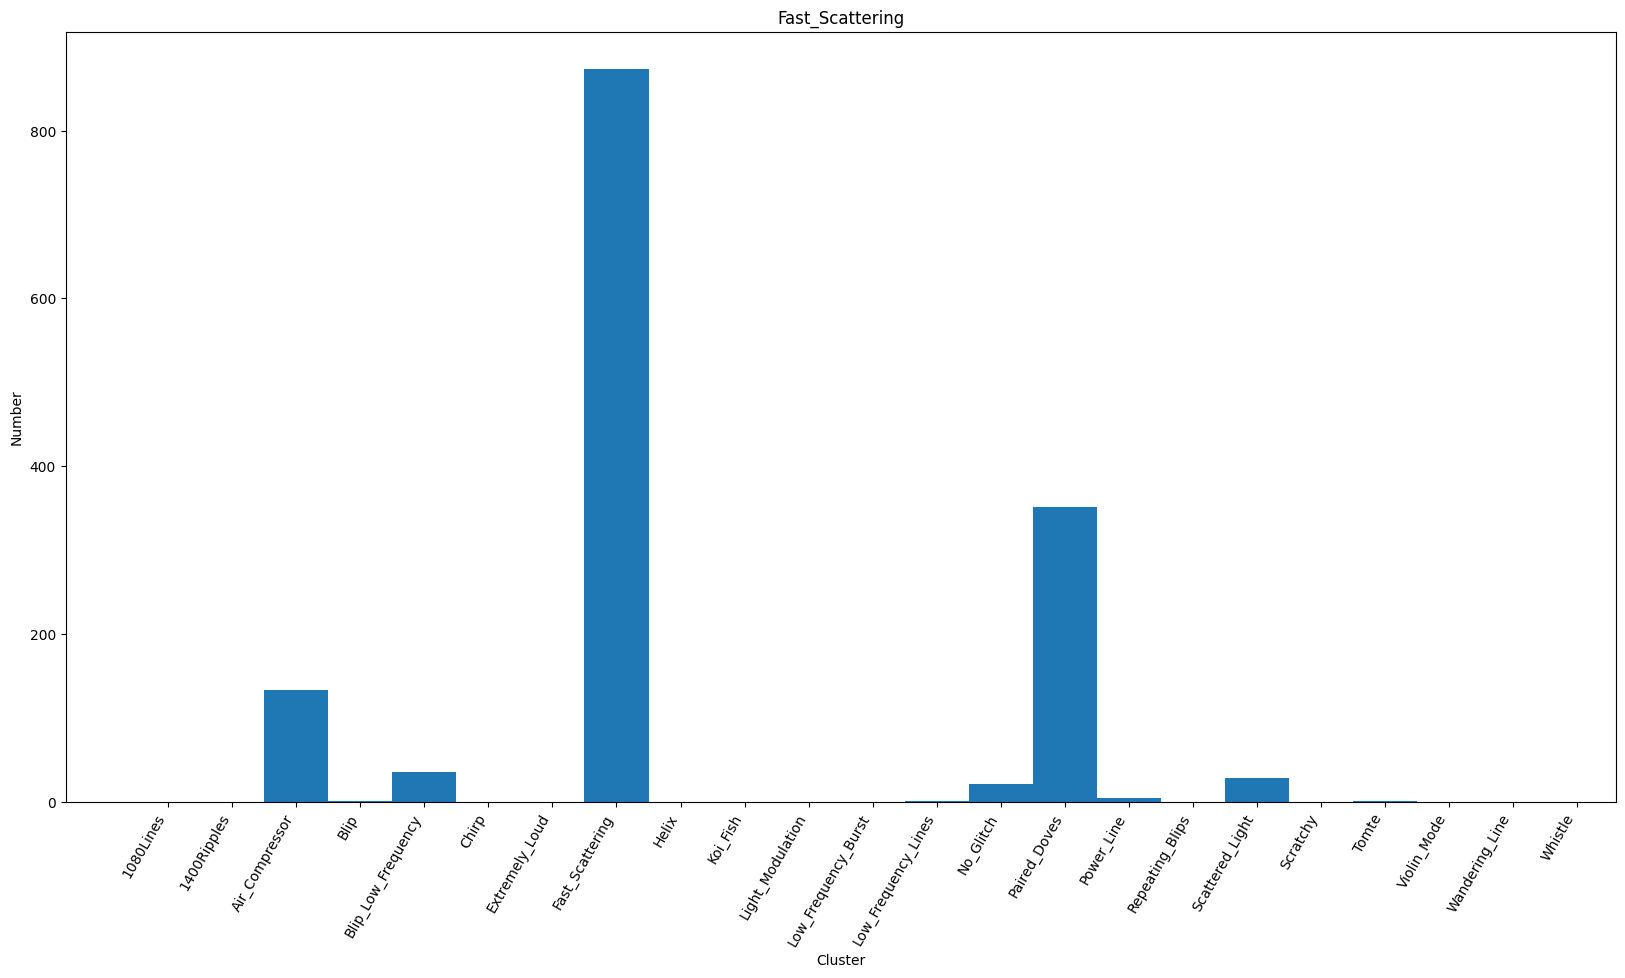

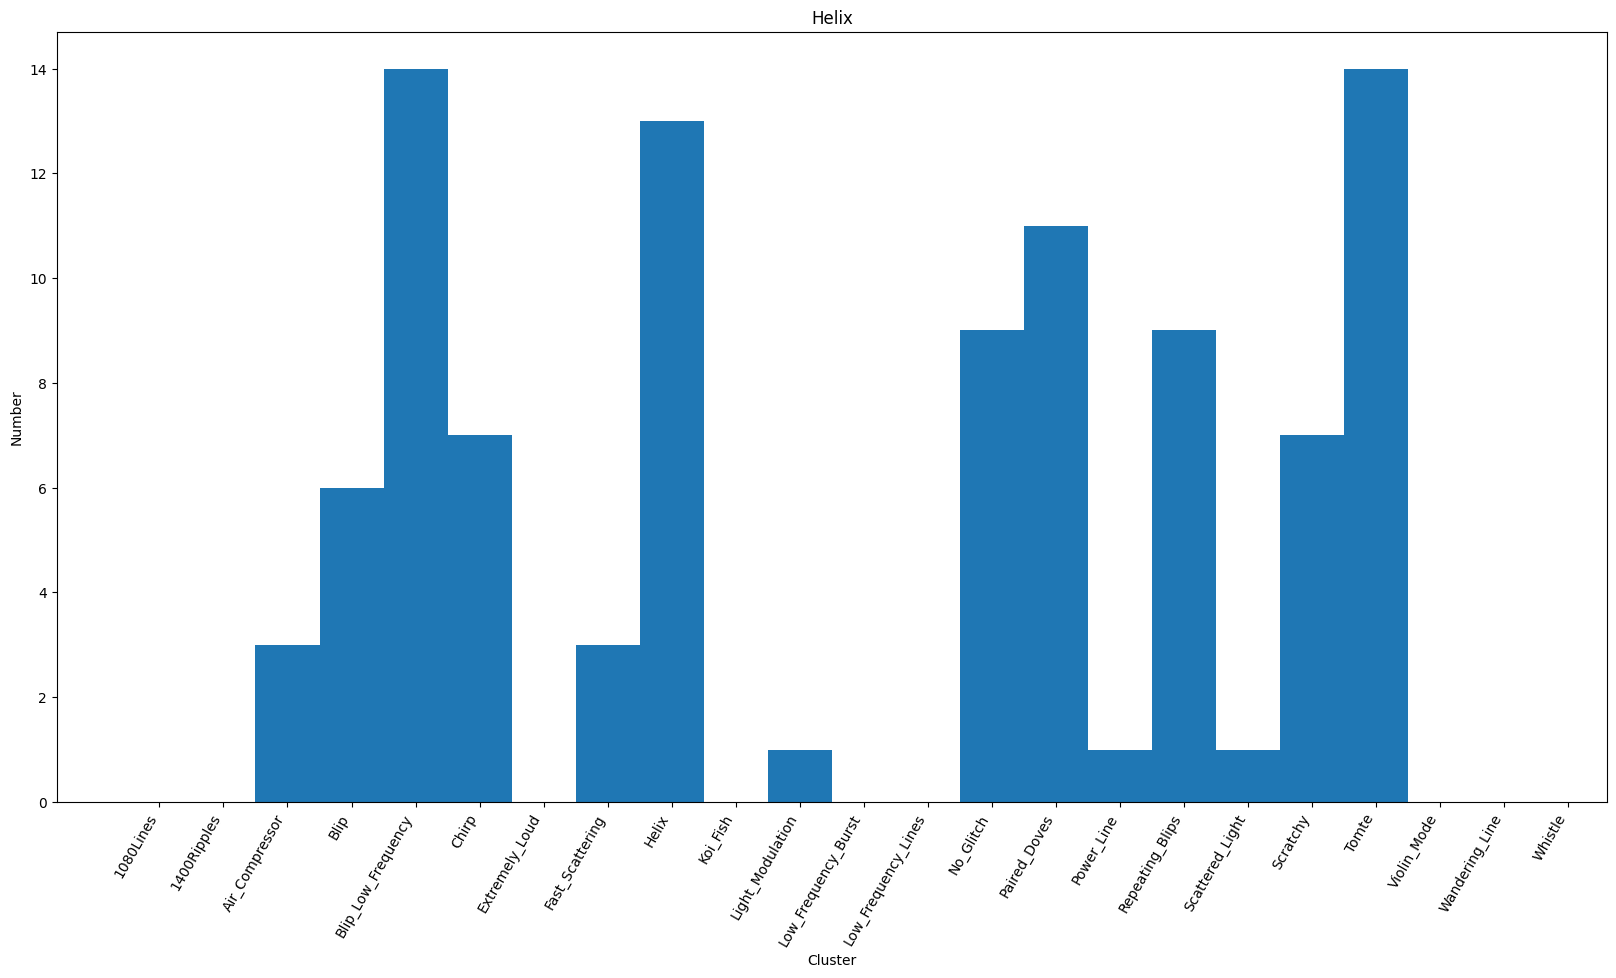

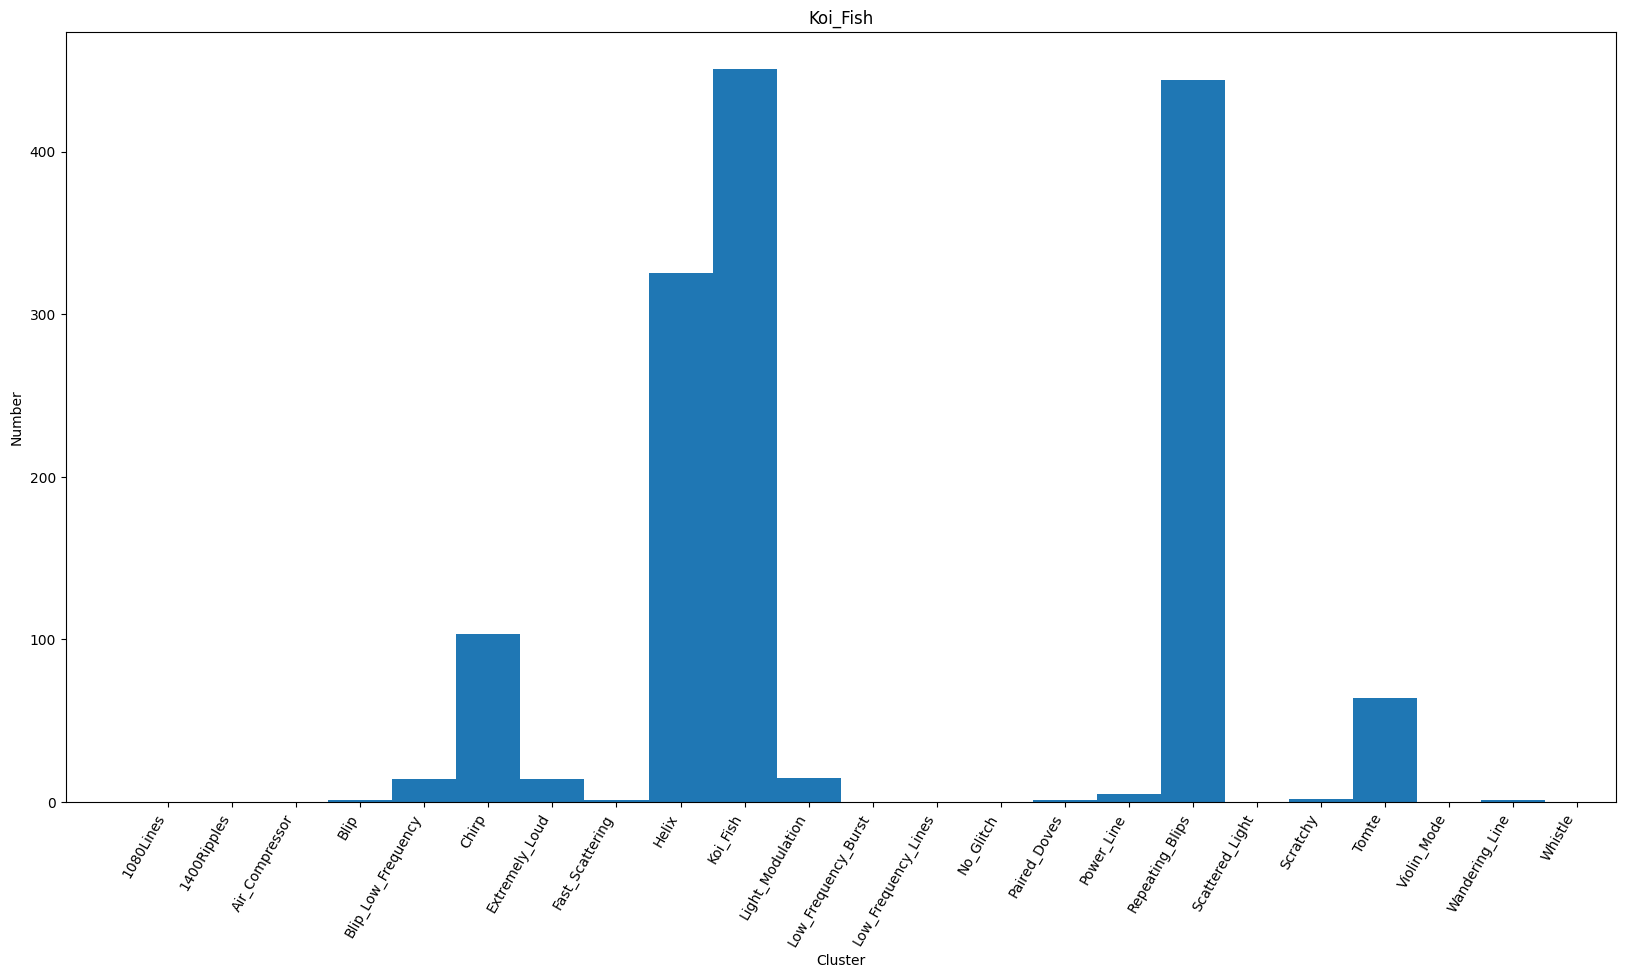

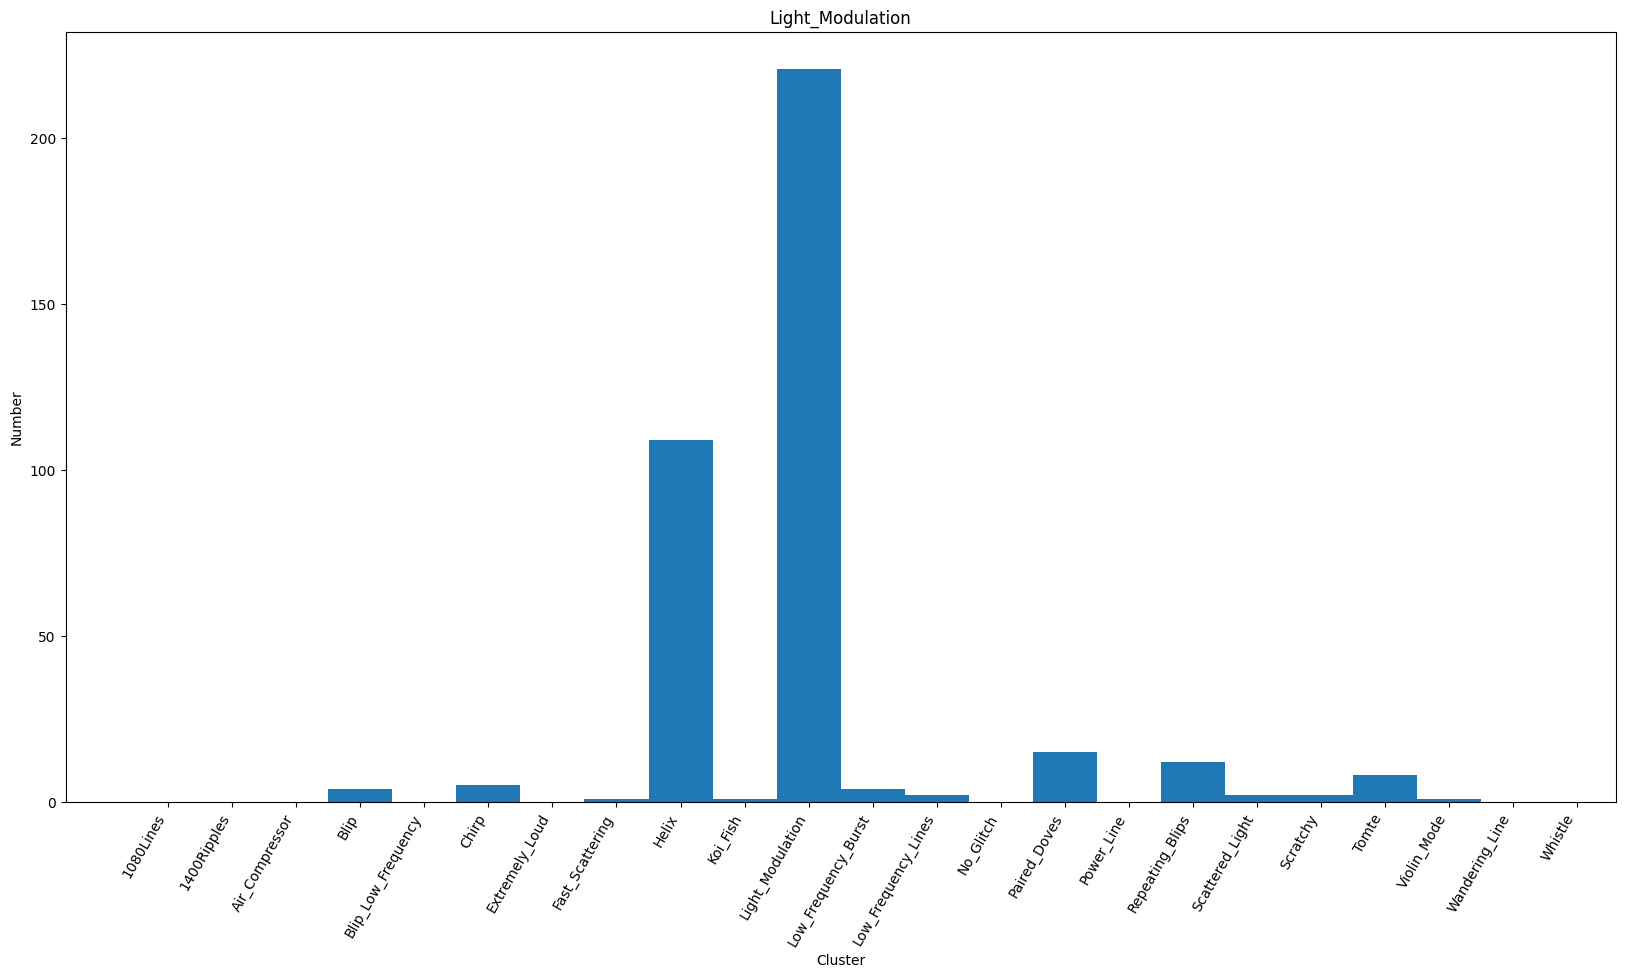

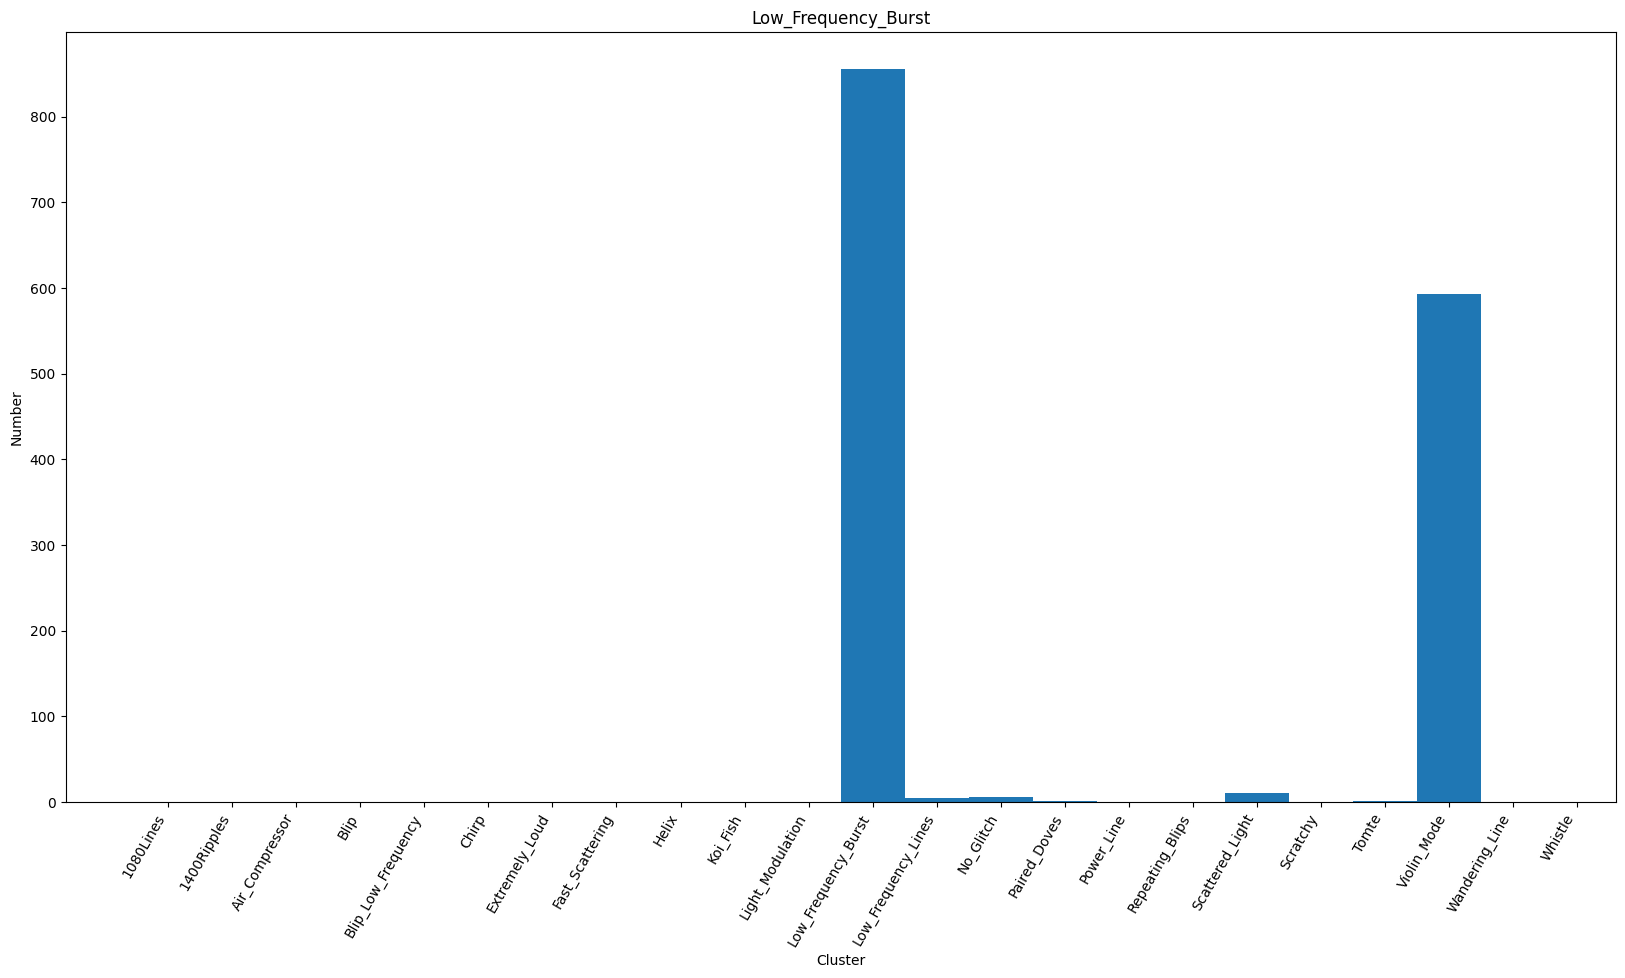

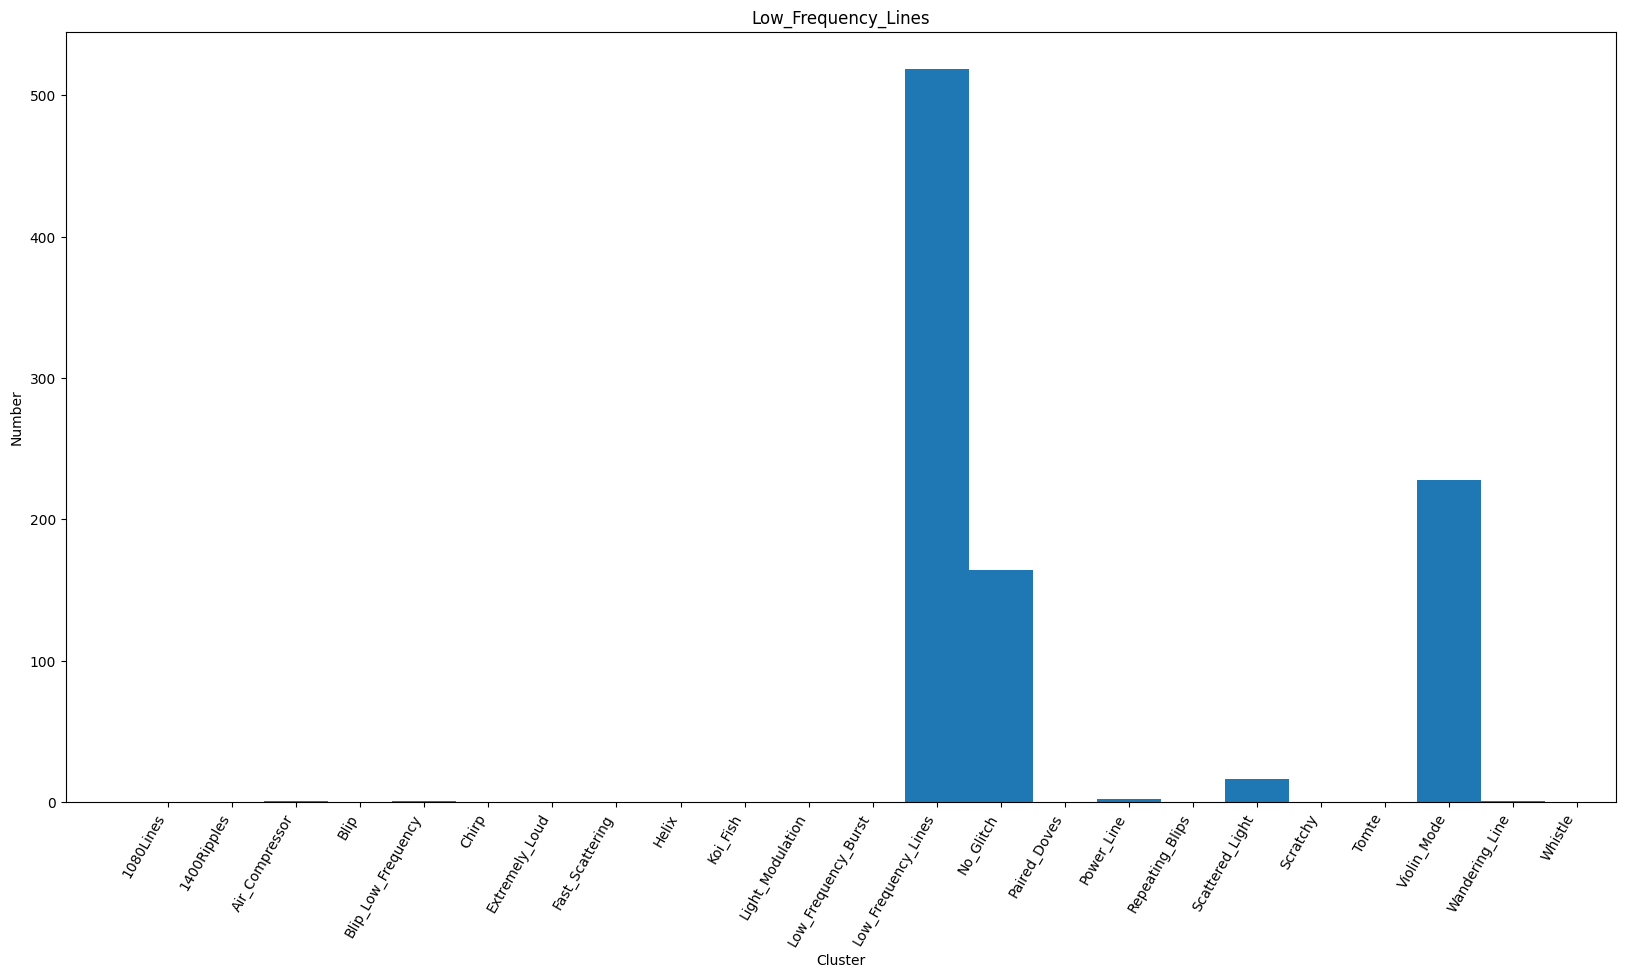

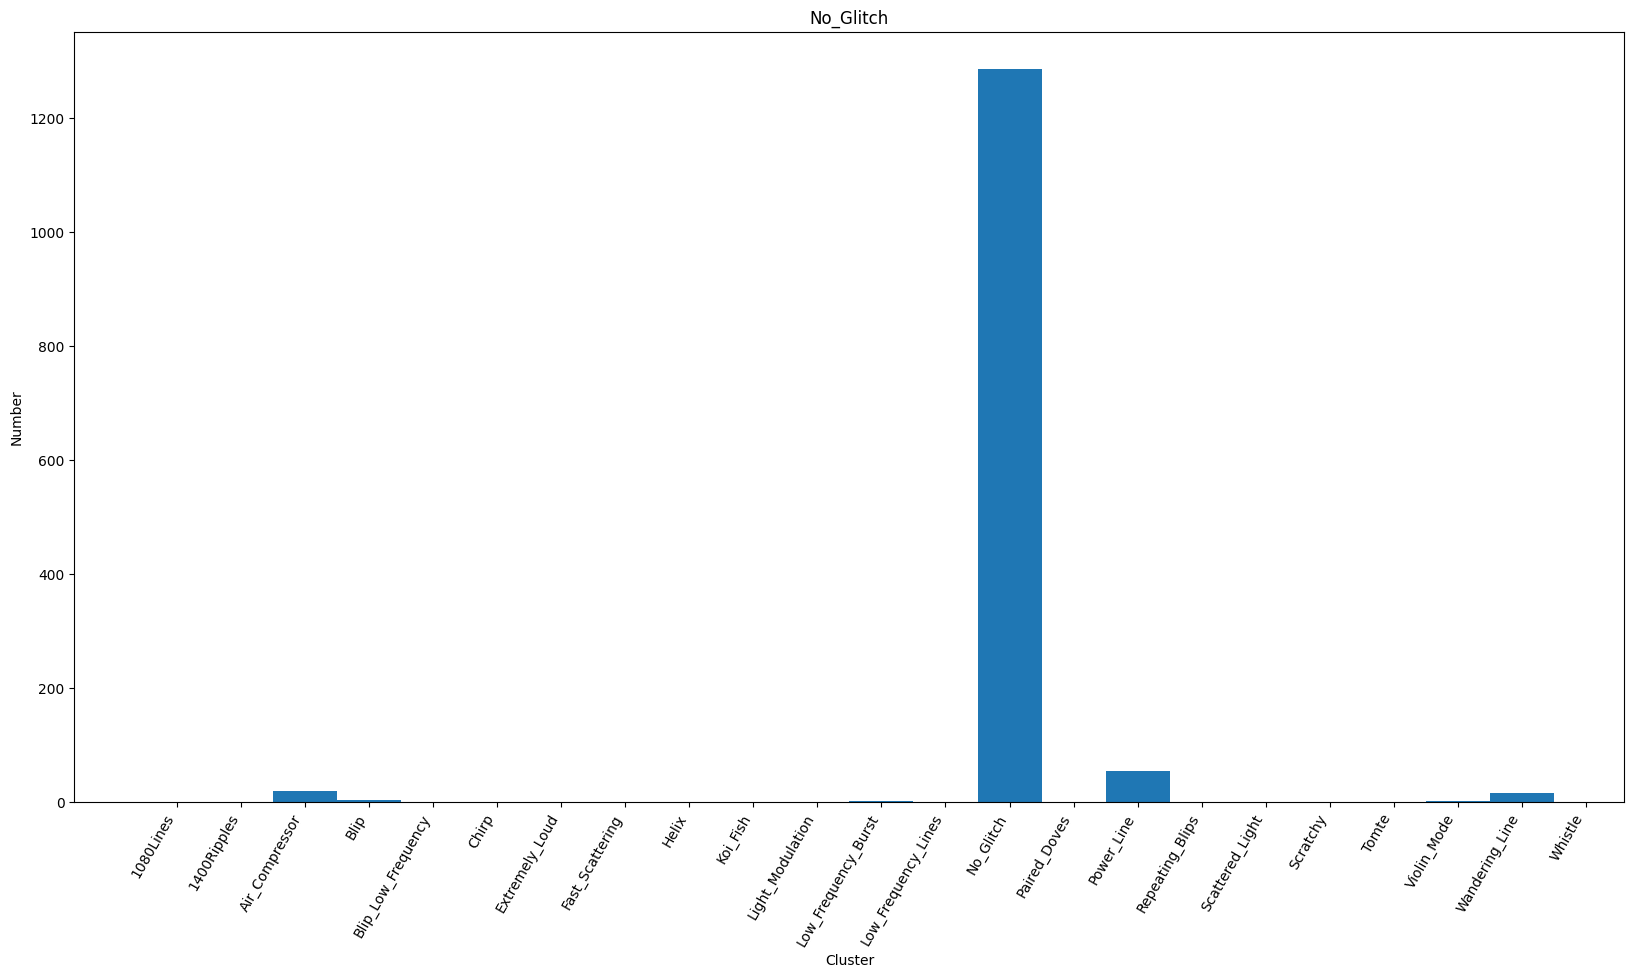

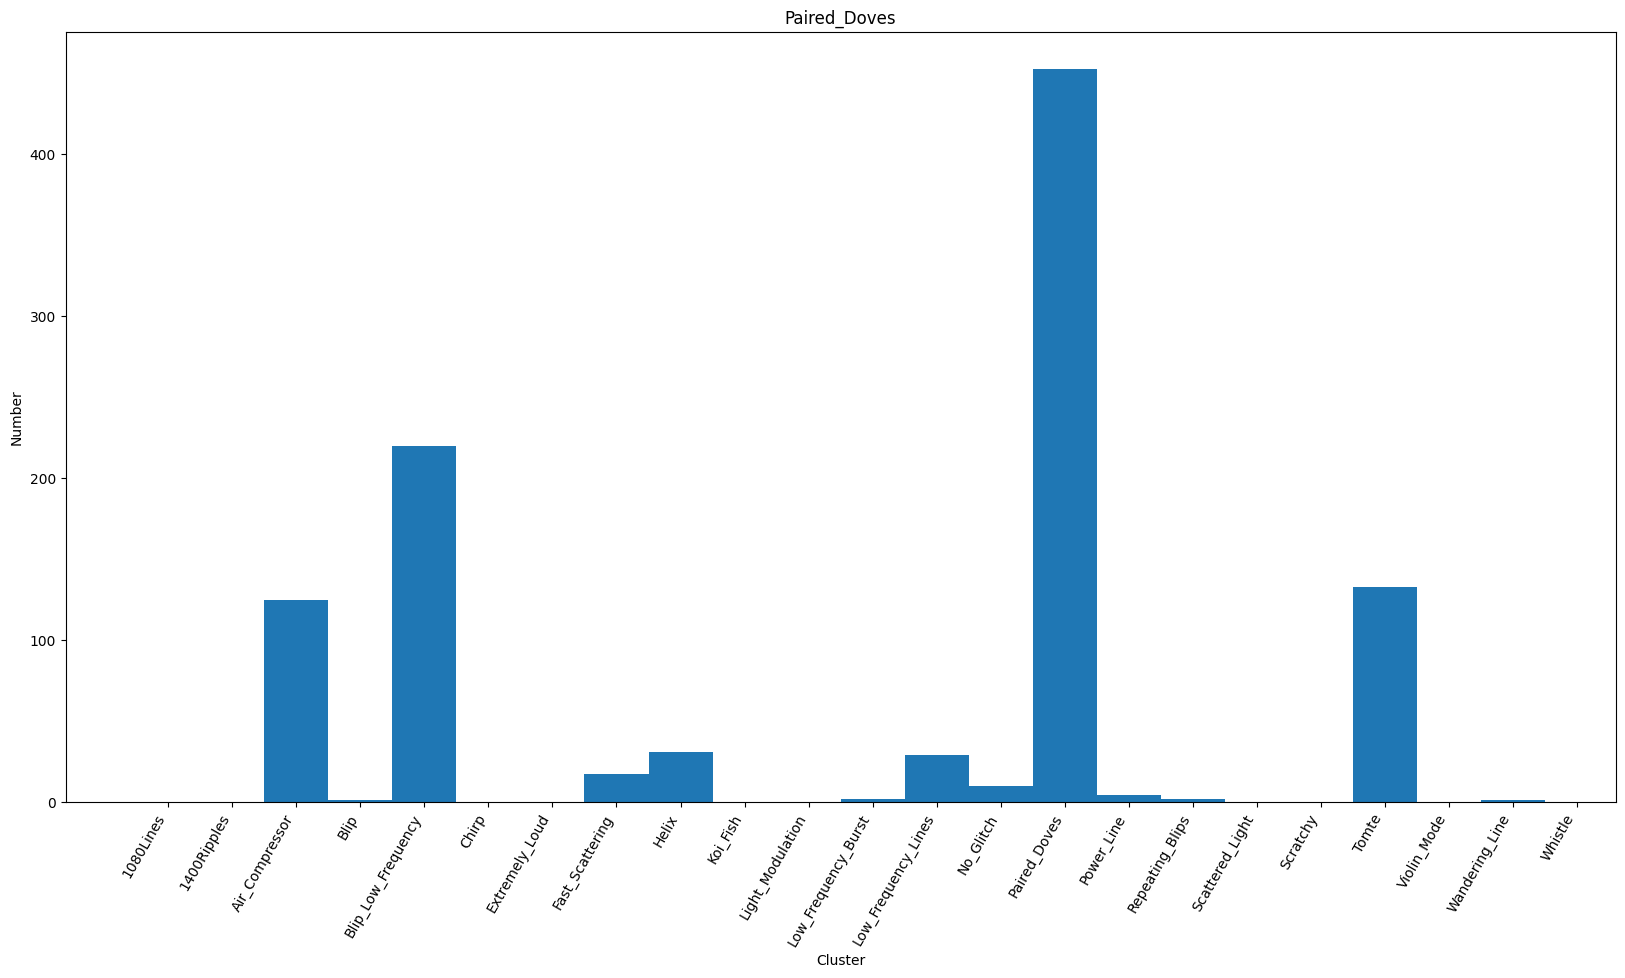

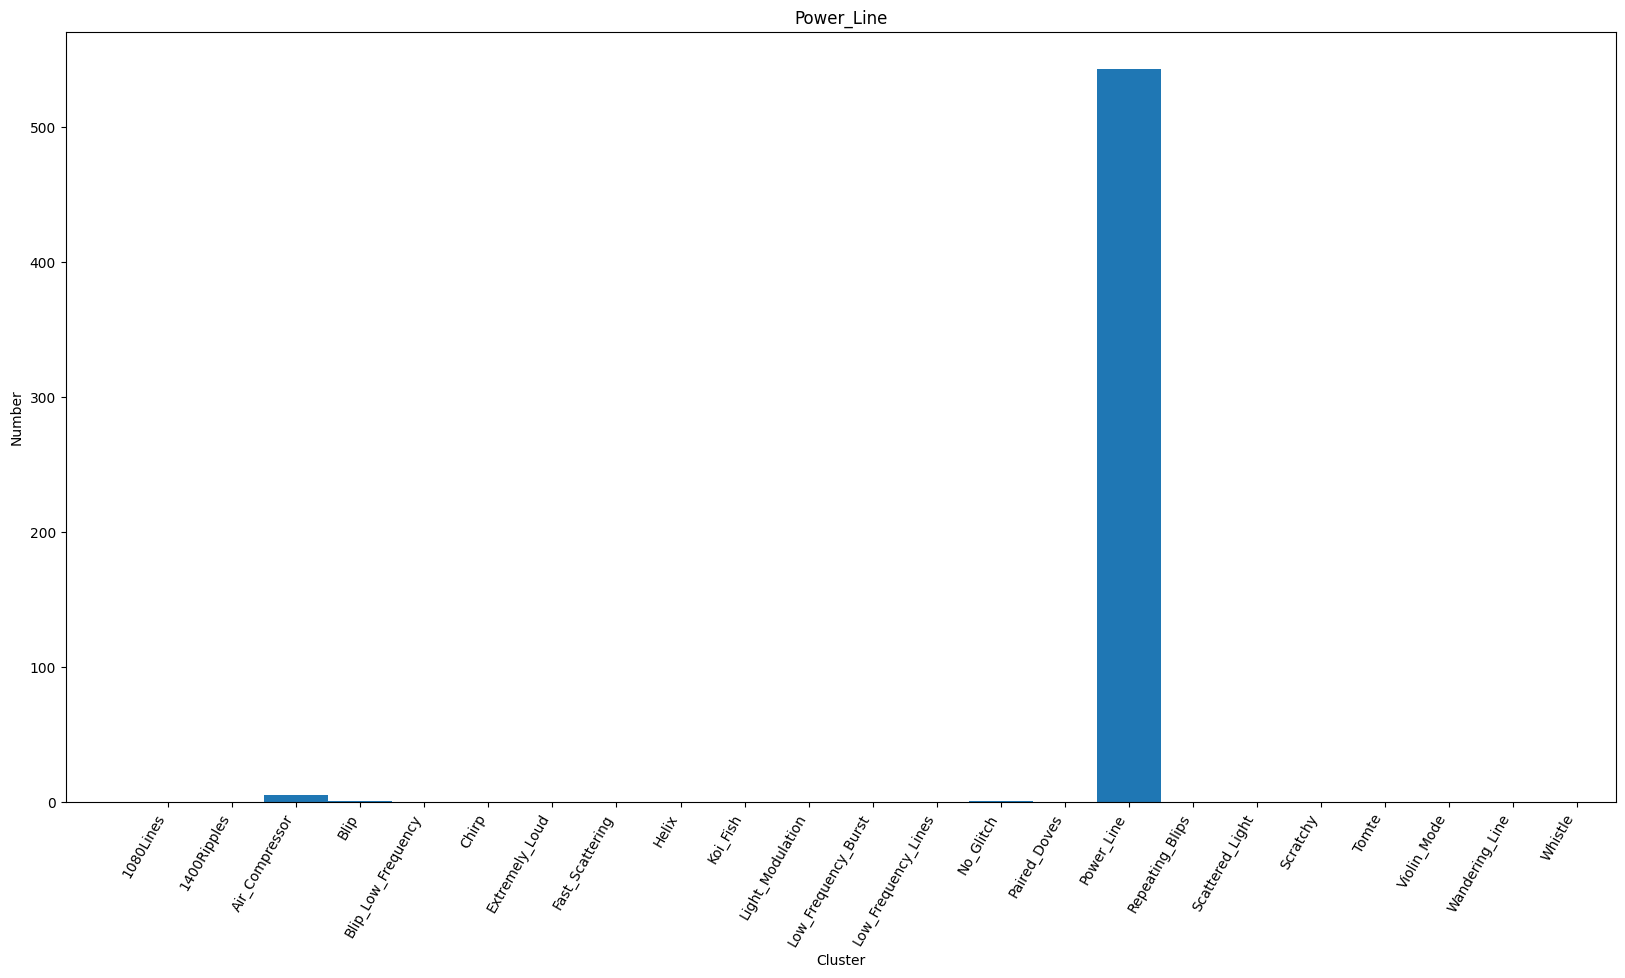

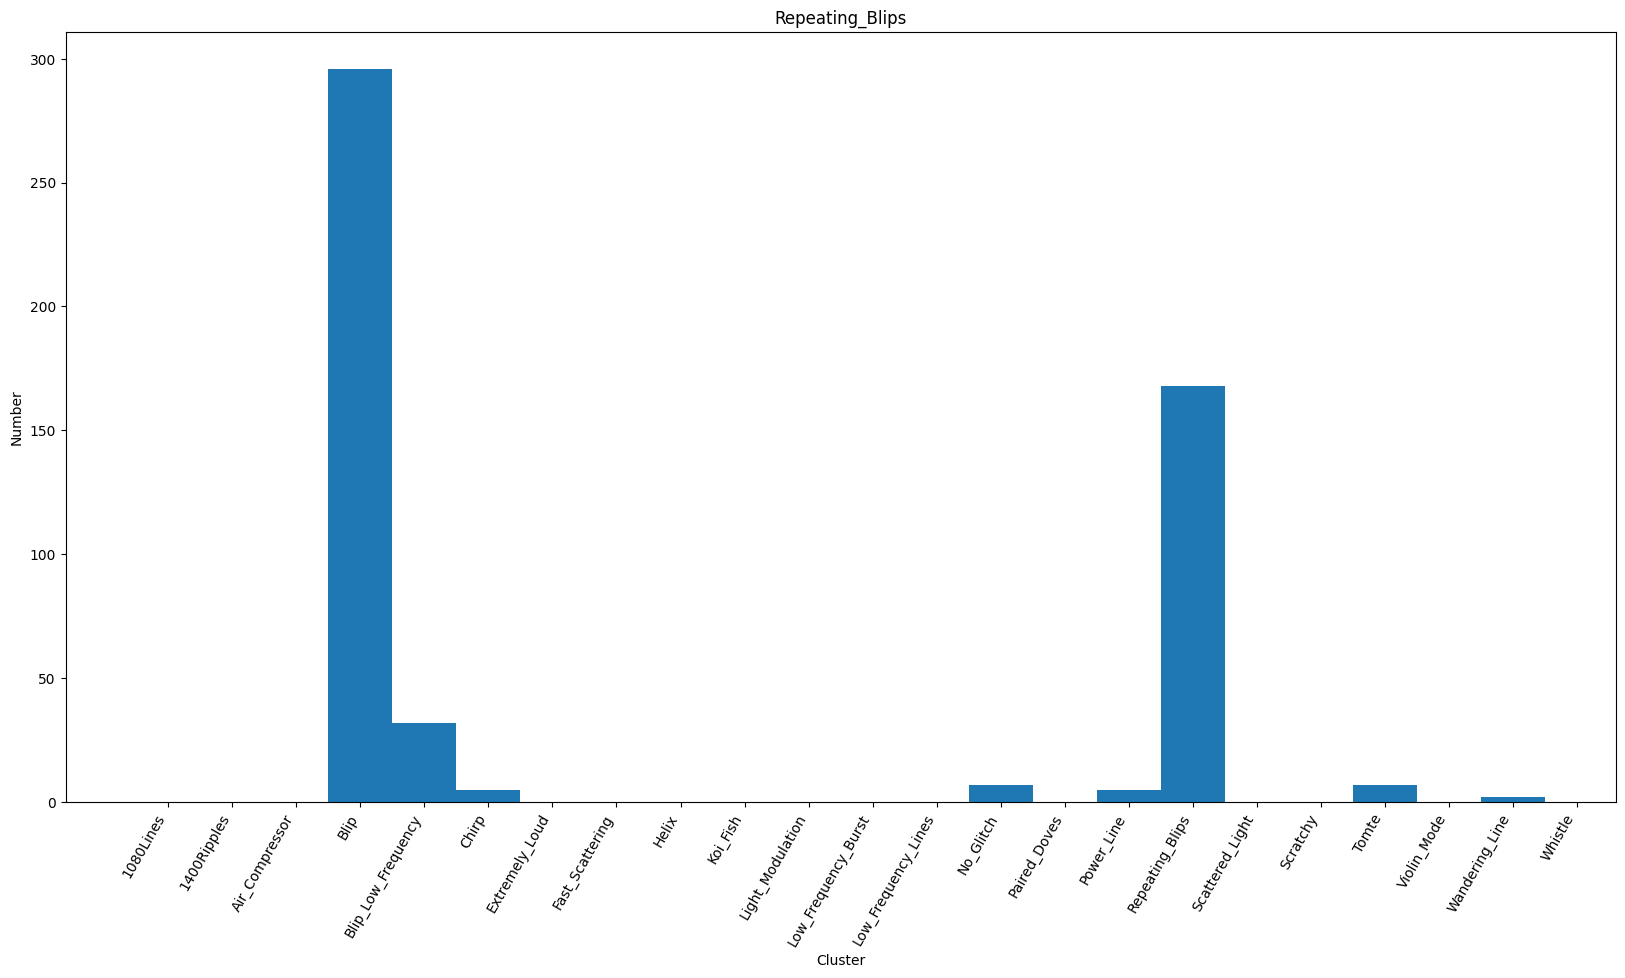

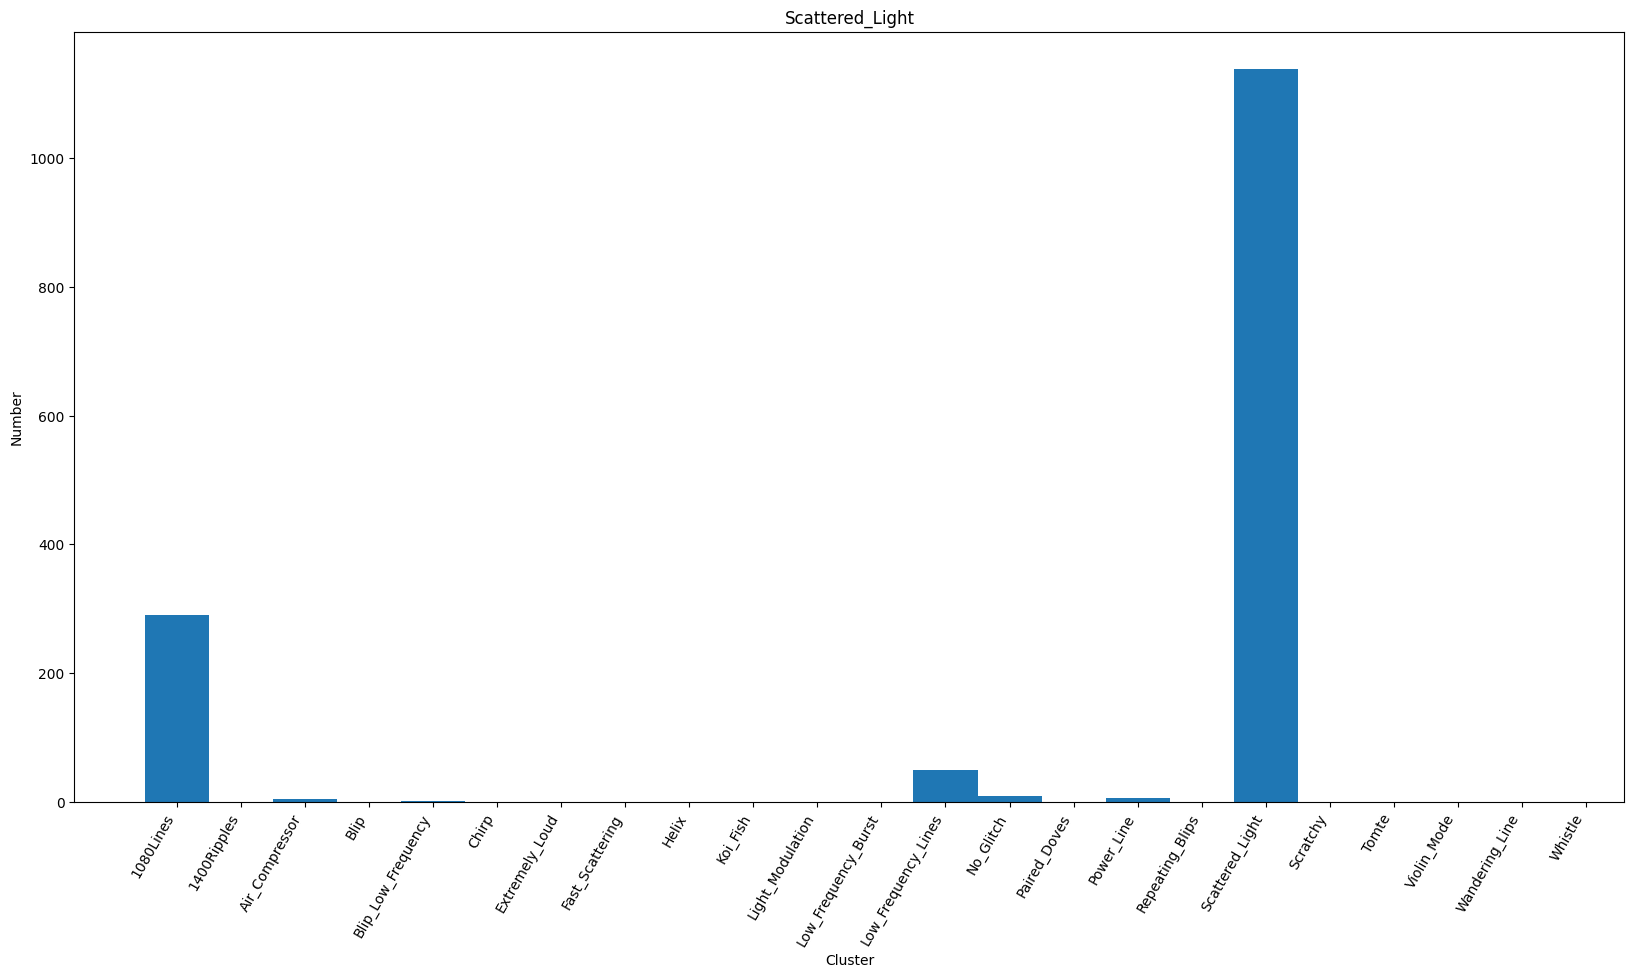

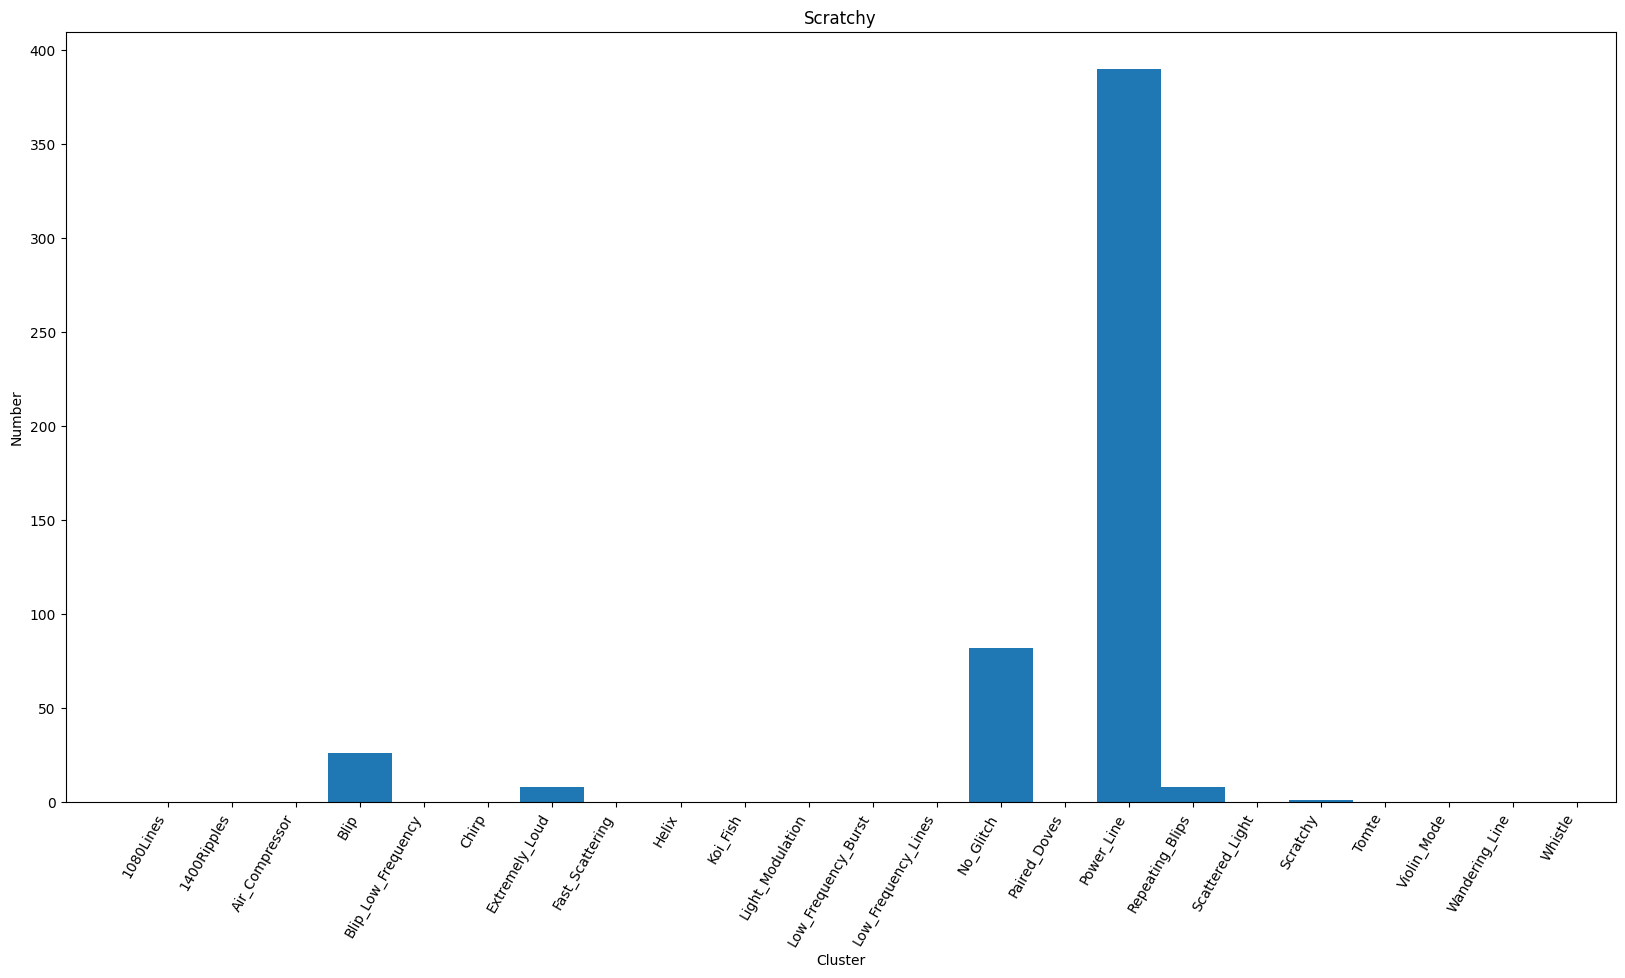

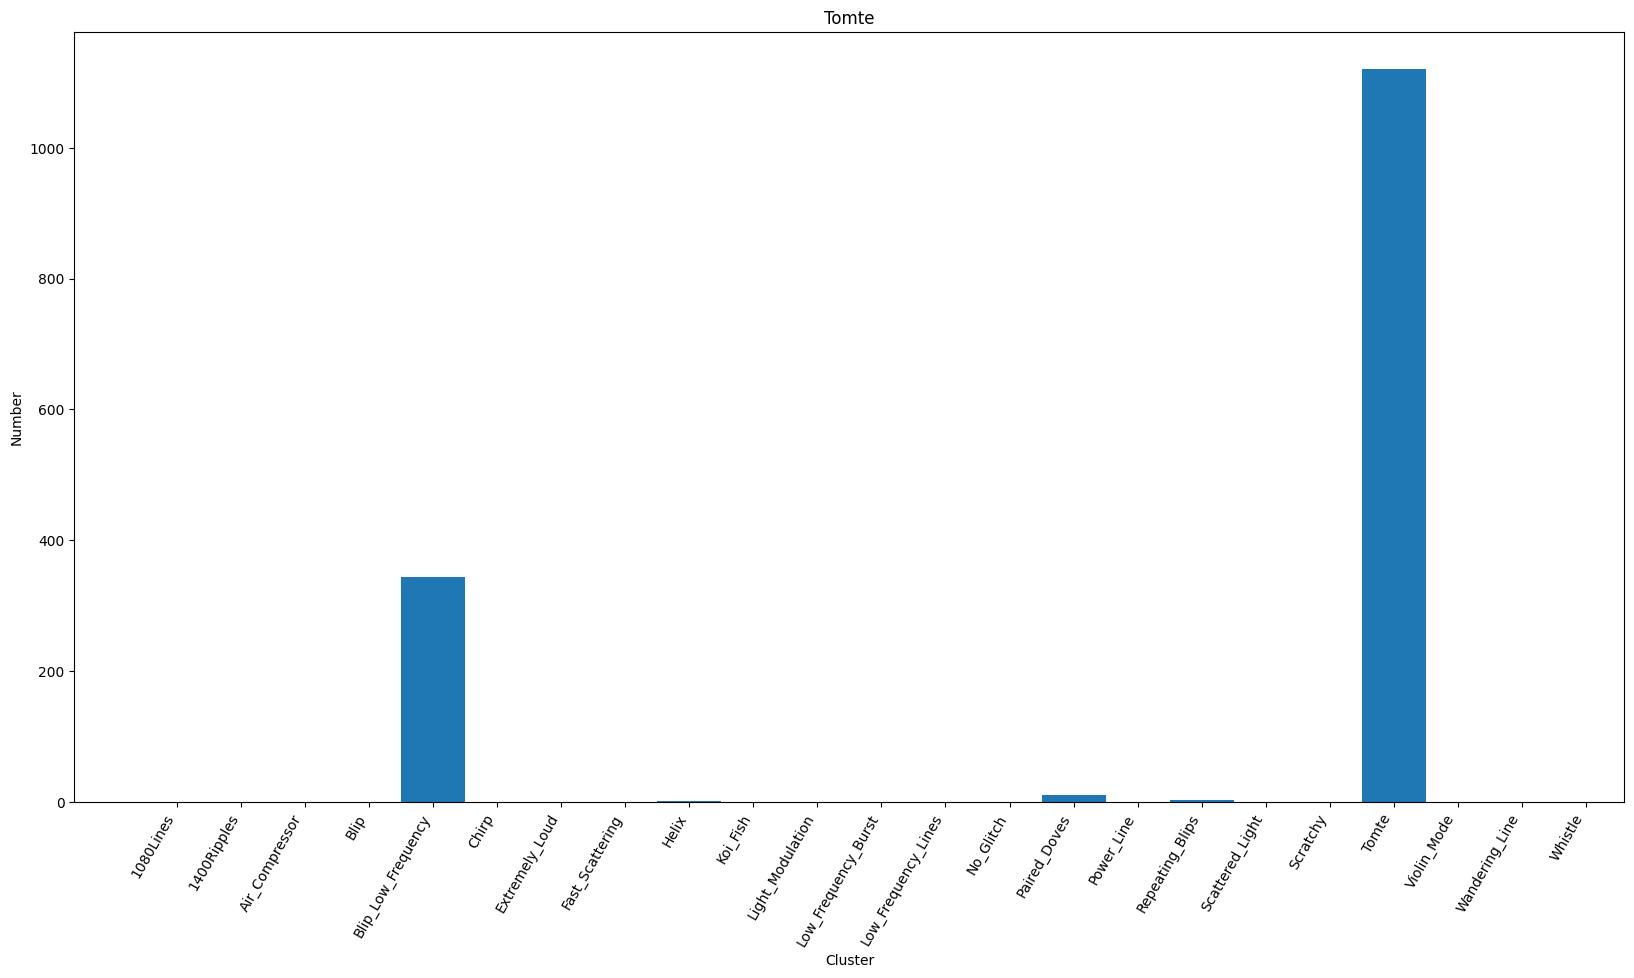

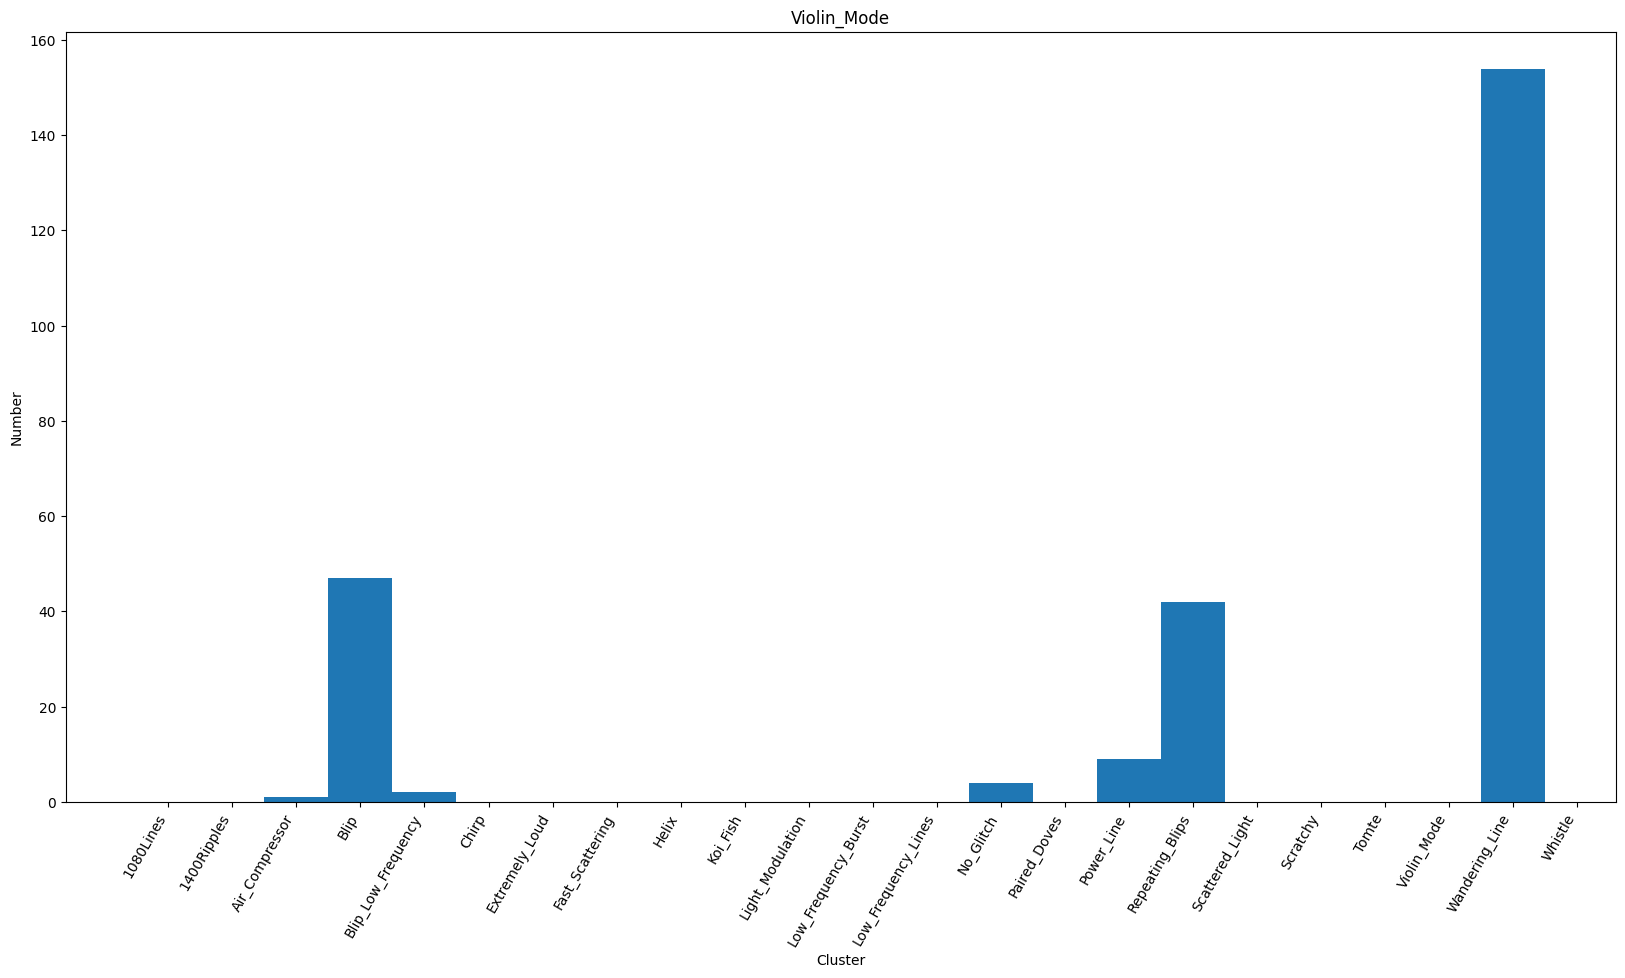

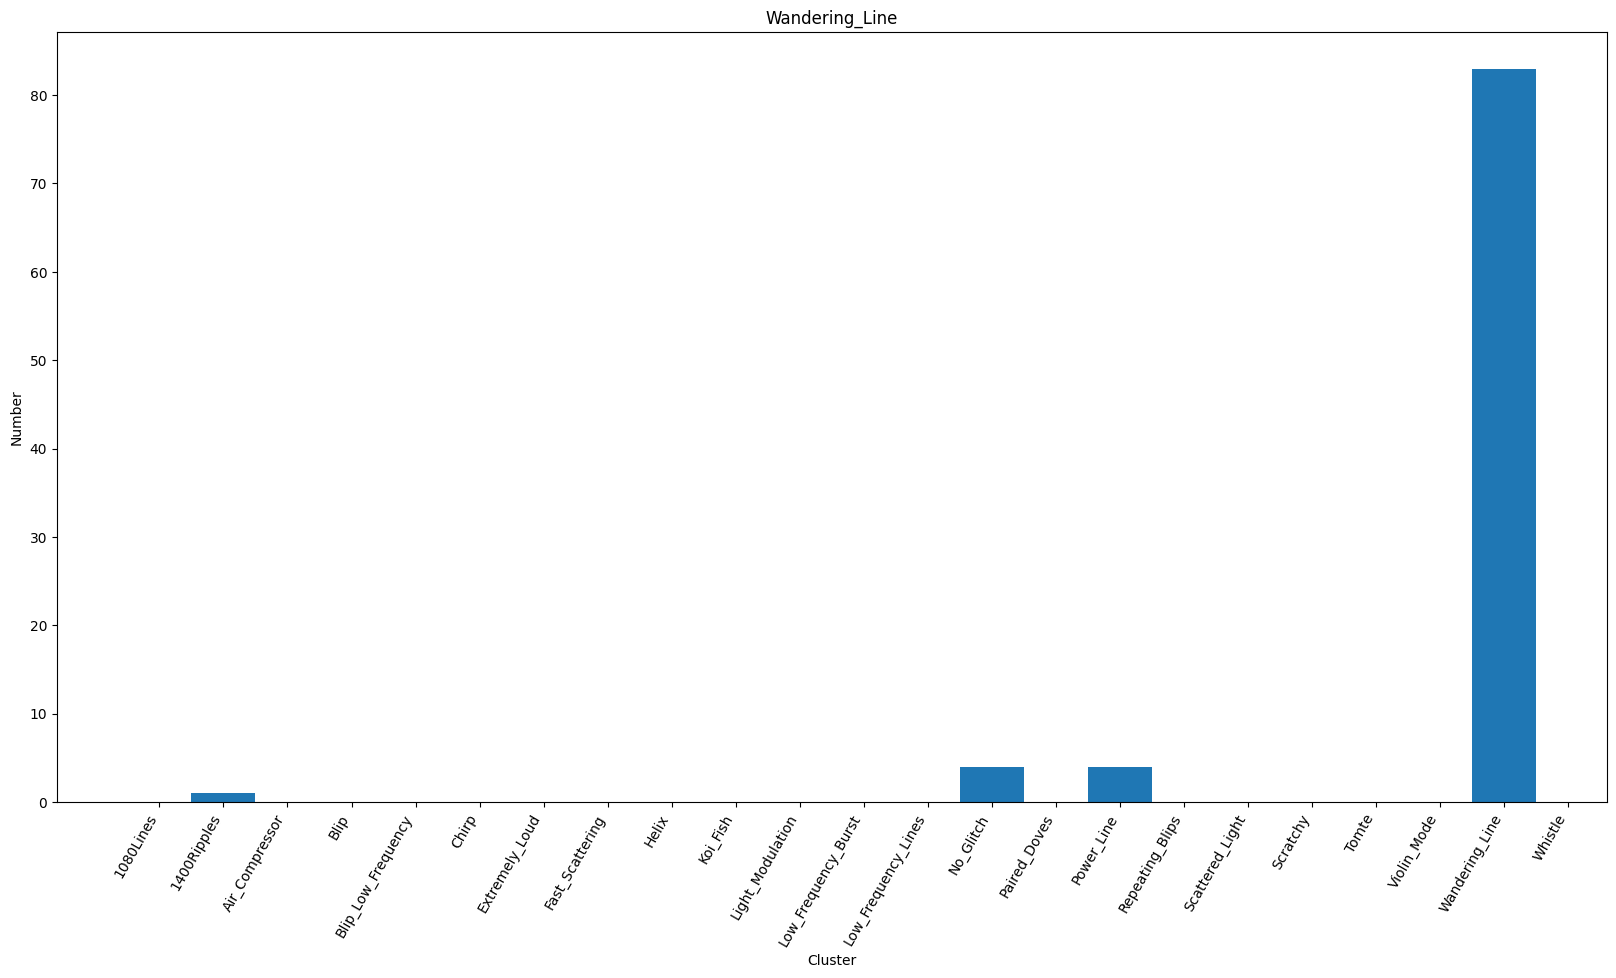

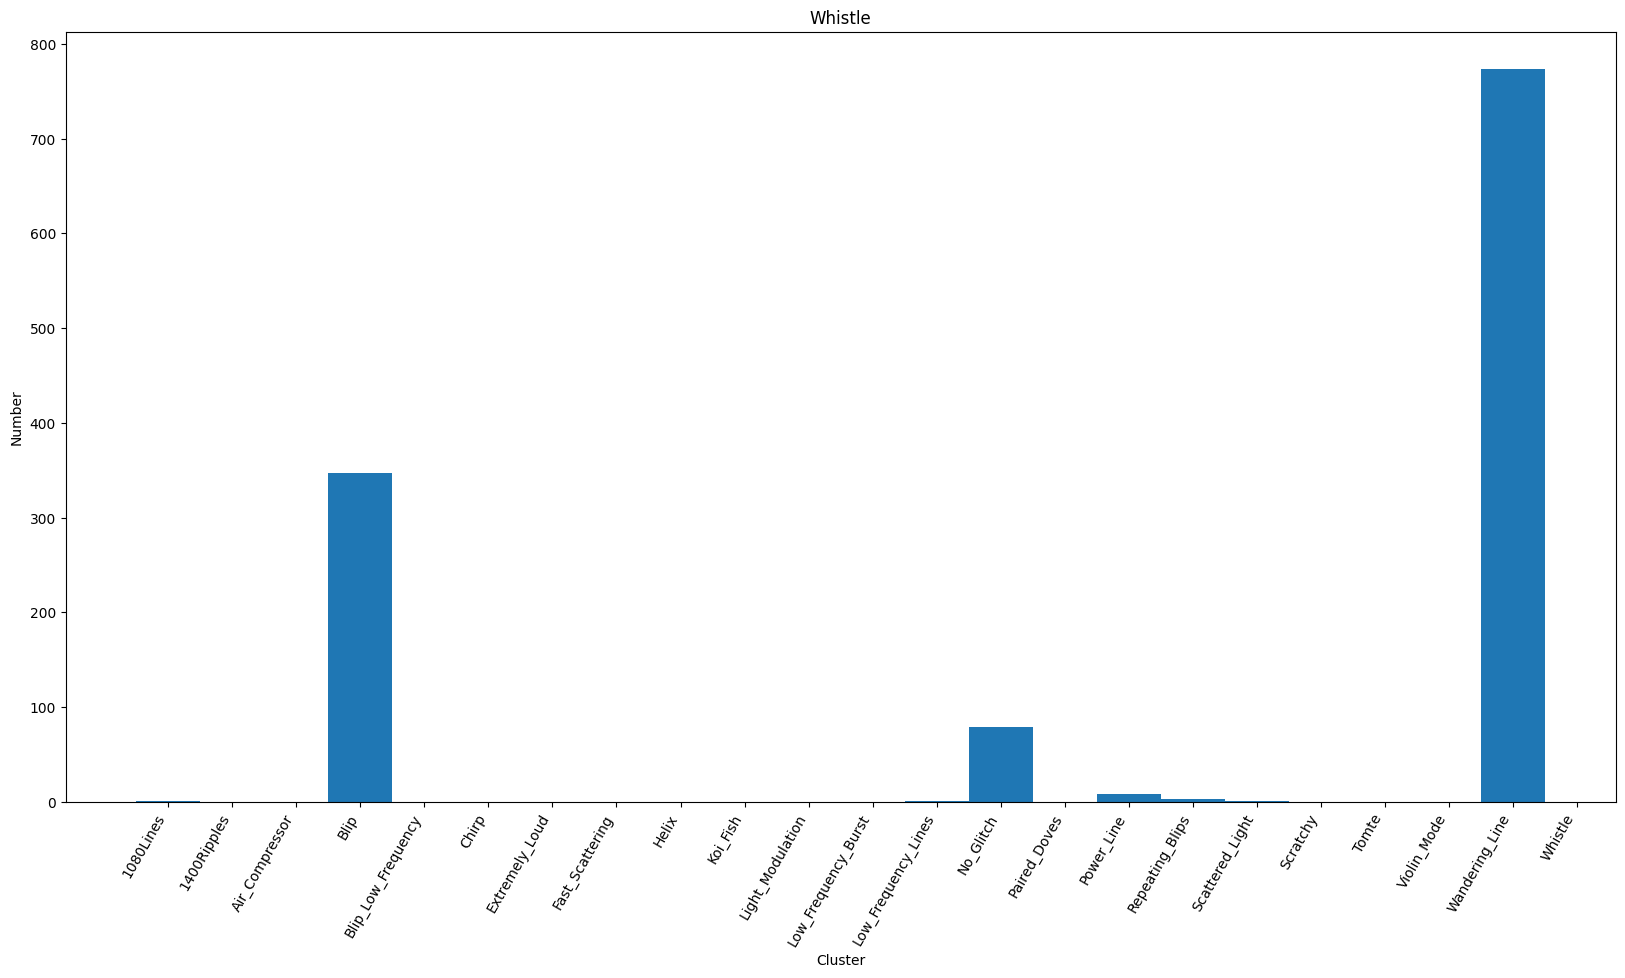

In [ ]:
for i, cluster in enumerate(clusters):
    fig, ax = plt.subplots(figsize=(20, 10))
    counts, bins, patches = ax.hist(cluster, list(range(len(classes))))
    ax.set_title(classes[i])
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Number")
    ax.set_xticks(bins + 0.5)
    ax.set_xticklabels(classes, rotation=60, ha="right")






In [ ]:
def confusion(actual, pred):

    tp_plus_fp = comb(np.bincount(actual), 2).sum()
    tp_plus_fn = comb(np.bincount(pred), 2).sum()
    A = np.c_[(actual, pred)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(actual))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return tp, tn, fp, fn

In [ ]:
cluster_map = {}
acc = []

tp, tn, fp, fn = confusion(labels, kmeans.labels_)
total_prec = tp / (tp + fp)
total_rec = tp / (tp + fn)
total_acc = (tp + tn) / (tp + tn + fp + fn)
total_ari = adjusted_rand_score(labels, kmeans.labels_)
total_nmi = normalized_mutual_info_score(labels, kmeans.labels_)





df = pd.DataFrame([f"{total_prec : .2f}", f"{total_rec : .2f}", f"{total_acc : .2f}", f"{total_ari : .2f}", f"{total_nmi : .2f}"], columns = ["score"], index=["precision", "recall", "accuracy", "adjusted RI", "nmi"])
print(df)

             score
precision     0.56
recall        0.51
accuracy      0.94
adjusted RI   0.50
nmi           0.70


In [ ]:
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=3, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(data)




KeyboardInterrupt: 

/tmp/ipykernel_25305/3989539021.py:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



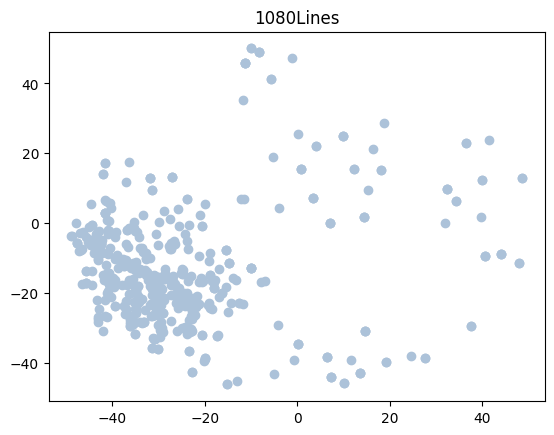

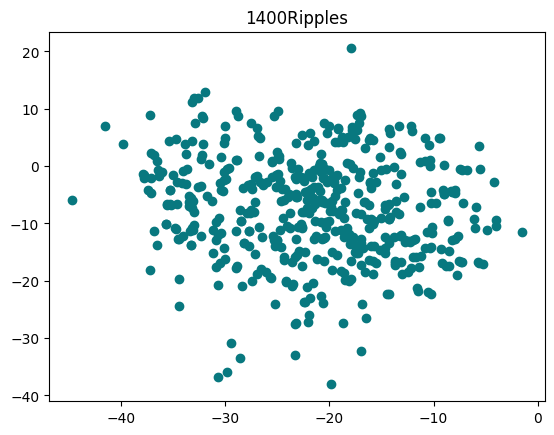

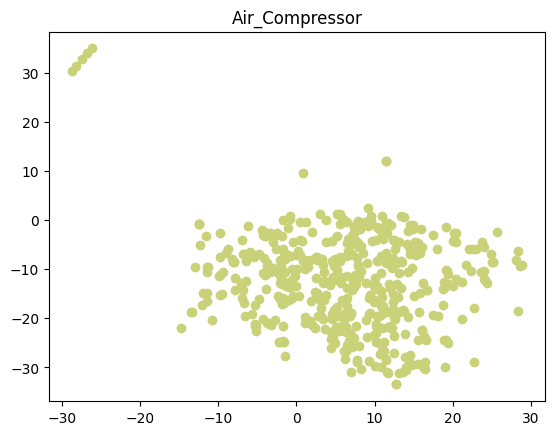

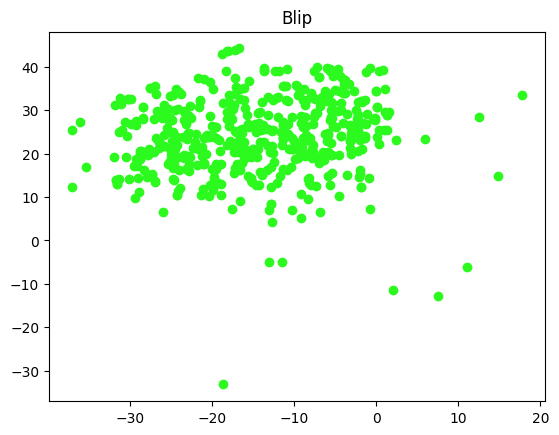

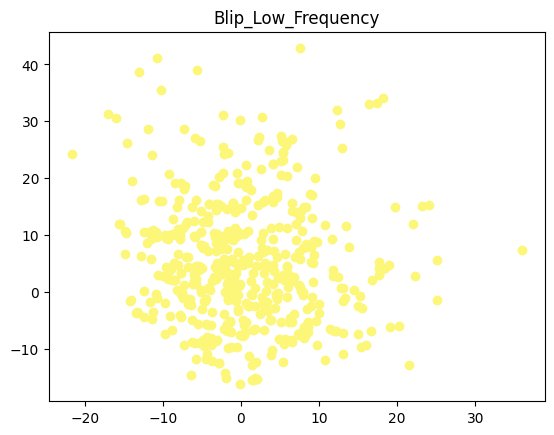

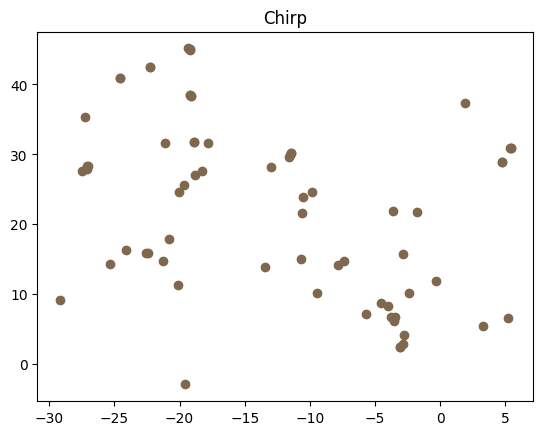

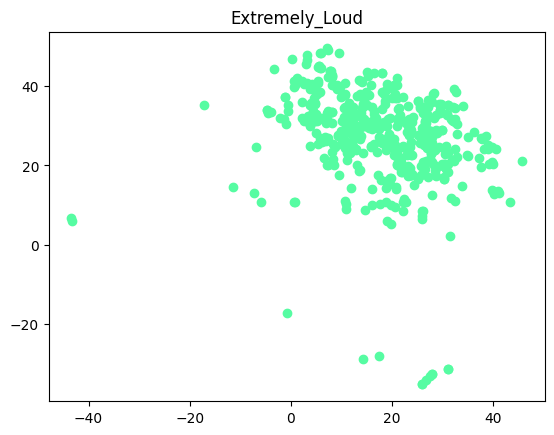

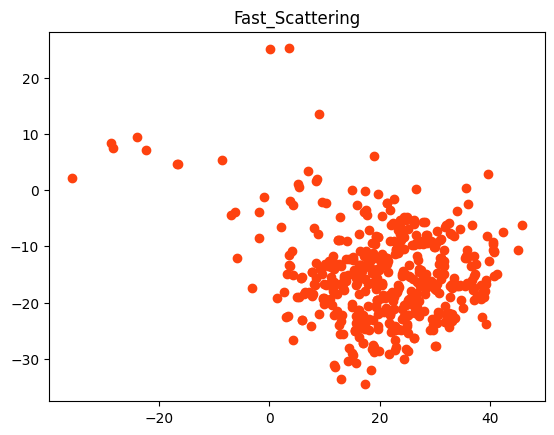

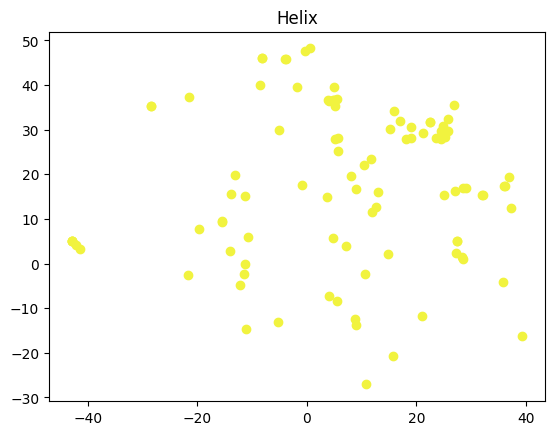

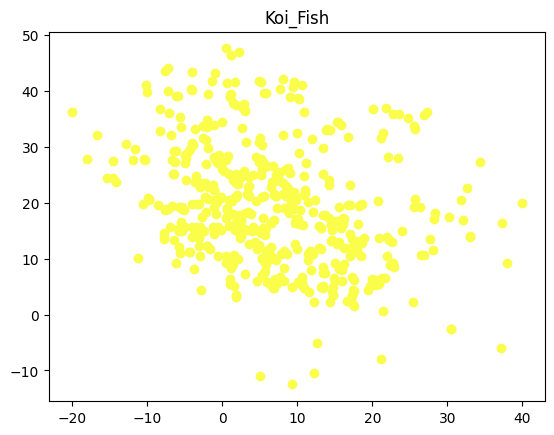

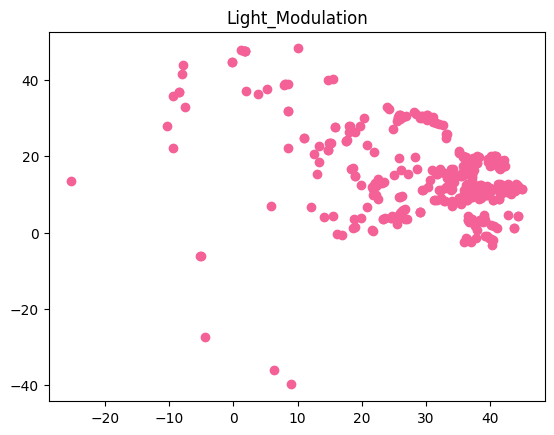

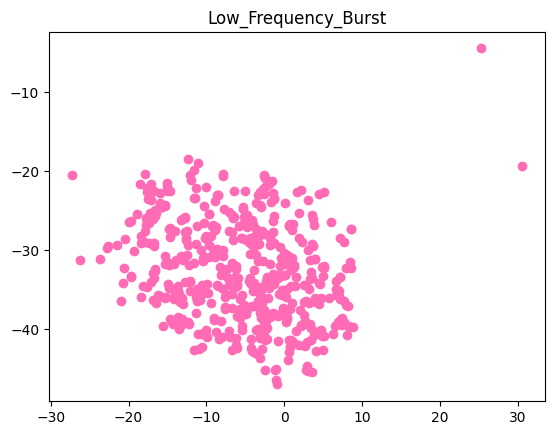

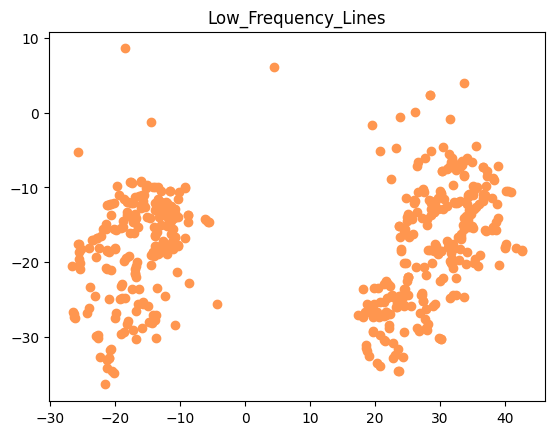

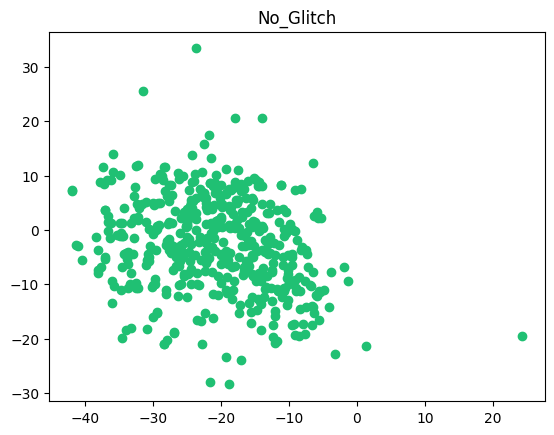

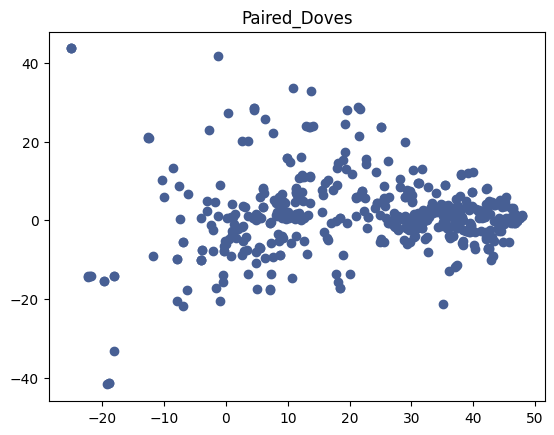

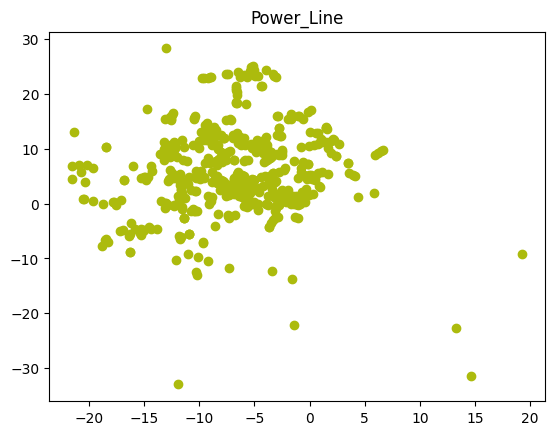

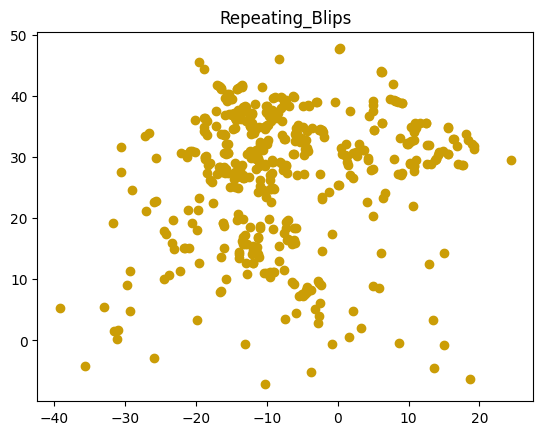

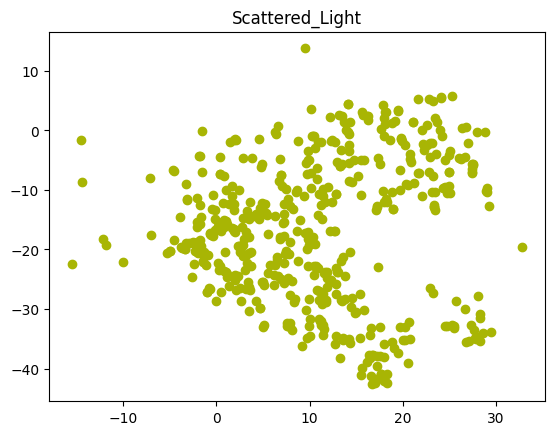

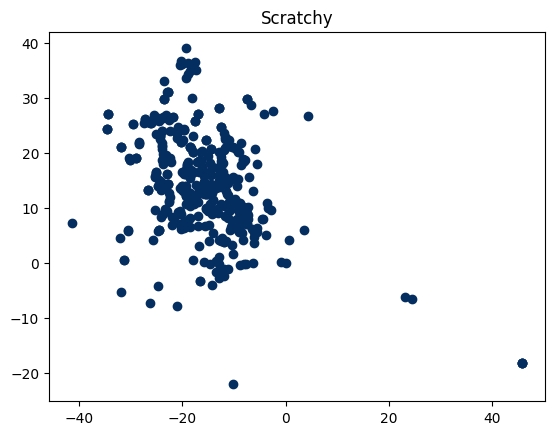

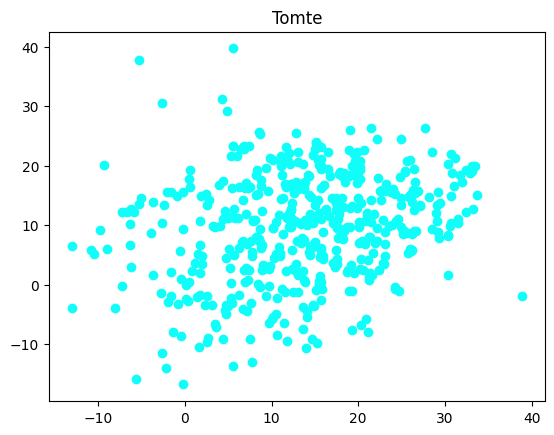

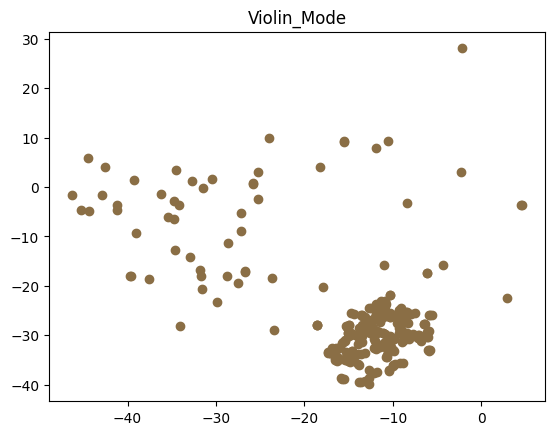

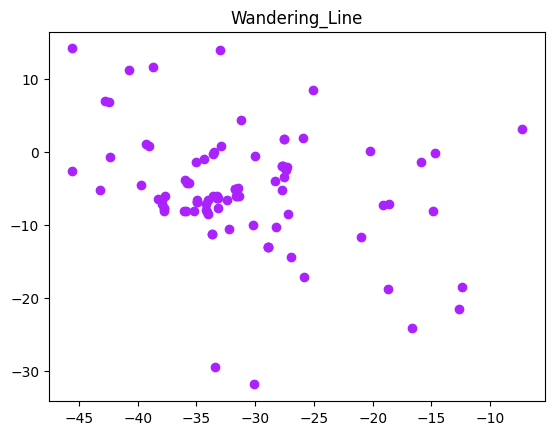

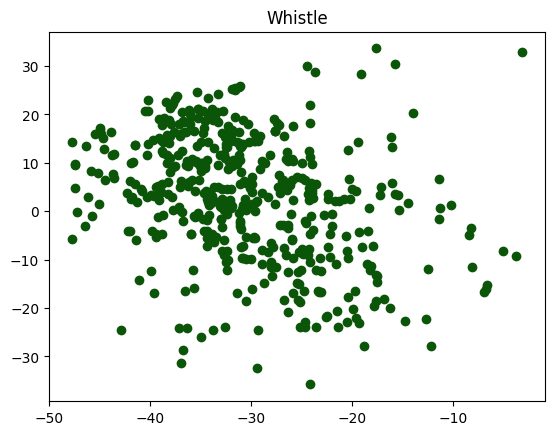

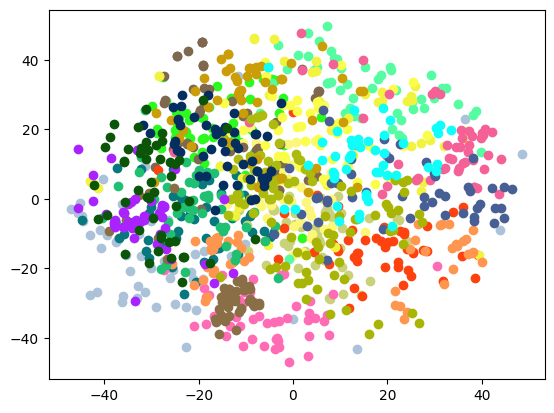

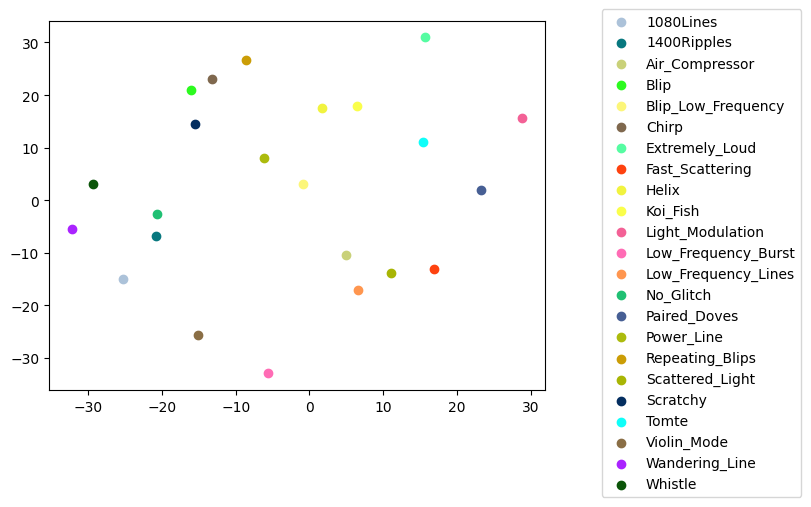

In [ ]:
import matplotlib._color_data as mcd
palette = list(mcd.XKCD_COLORS.values())[::10]



for i in range(len(classes)):
    mask = (labels == i)
    x_show = x_embedded[mask, :][:500, :]
    plt.figure()
    plt.scatter(x_show[:, 0], x_show[:, 1], color=palette[3 * i])
    plt.title(classes[i])


plt.figure()
for i in range(len(classes)):
    mask = (labels == i)
    x_show = x_embedded[mask, :][:50, :]
    
    plt.scatter(x_show[:, 0], x_show[:, 1], color=palette[3 * i])

plt.figure()
for i in range(len(classes)):
    mask = (labels == i)
    x_show = x_embedded[mask, :][:50, :].mean(0, keepdims=True)
    
    plt.scatter(x_show[:, 0], x_show[:, 1], color=palette[3 * i], label=classes[i])
    plt.legend(bbox_to_anchor=(1.1, 1.05))



In [ ]:
x_embedded = TSNE(n_components=3, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(data)




KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.graph_objs import *

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()







for i in range(len(classes)):
    mask = (labels == i)
    x_show = x_embedded[mask, :][:500, :]
    # Configure the trace.
    trace = go.Scatter3d(
        x=x_show[:, 0],  
        y=x_show[:, 1], 
        z=x_show[:, 2], 
        mode='markers',
        marker={
            'size': 10,
            'opacity': 0.8,
        },
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
        scene=Scene(
                xaxis=XAxis(title=classes[i]),
                yaxis=YAxis(title=classes[i]),
                zaxis=ZAxis(title=classes[i])
            )
    )

    data = [trace]

    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)





In [ ]:
data = []
for i in range(len(classes)):
    mask = (labels == i)
    x_show = x_embedded[mask, :][:100, :]
    cluster = kmeans.labels_[mask]
    # mask = cluster == 14
    # x_show = x_show[mask]
    # Configure the trace.
    trace = go.Scatter3d(
        x=x_show[:, 0],  
        y=x_show[:, 1], 
        z=x_show[:, 2], 
        mode='markers',
        marker={
            'size': 10,
            'opacity': 0.8,
        },
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
        scene=Scene(
                xaxis=XAxis(title=classes[i]),
                yaxis=YAxis(title=classes[i]),
                zaxis=ZAxis(title=classes[i])
            )
    )

    data.append(trace)

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

